In [1]:
from model import *
import numpy as np
from util import *

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.manifold import TSNE
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram

def HGMM(n_class, dim, margin):
    margin = margin
    mean = np.zeros((n_class , dim))
    #mean[:(n_class // 2), 0] = margin
    #mean[(n_class // 2):, 0] = -margin
    ratio = n_class // 2
    index = 0
    while ratio != 0:
        for i in range(int(n_class // ratio)):
            mean[i*ratio:(i+1)*ratio, index] = (-1) ** i * margin / (2**index)
        #for i in range(8):
            #mean[i*1:(i+1)*1, 2] = (-1) ** i * margin / 4
        ratio = ratio // 2
        index += 1
    return mean
dim = 100
margin = 8
n_class = 8
var = 1

def gen_synthetic(dim, margin, n_class, var, num =100):
    mean = HGMM(n_class, dim, margin)
    data = np.random.multivariate_normal(mean[0], np.identity(dim), num)
    cla = np.zeros(num)
    for i in range(1, n_class):
        cla = np.concatenate([cla, i*np.ones(num)])
        data = np.concatenate([data, np.random.multivariate_normal(mean[i], var * np.identity(dim), num)])
    return data, cla


In [5]:
class VaDE(nn.Module):
    def __init__(self,nClusters, hid_dim, input_dim = 100):
        super(VaDE,self).__init__()
        self.encoder=Encoder(input_dim)
        self.decoder=Decoder(input_dim)

        self.pi_=nn.Parameter(torch.FloatTensor(nClusters,).fill_(1)/nClusters,requires_grad=True)
        self.mu_c=nn.Parameter(torch.FloatTensor(nClusters,hid_dim).fill_(0),requires_grad=True)
        self.log_sigma2_c=nn.Parameter(torch.FloatTensor(nClusters,hid_dim).fill_(0),requires_grad=True)
        self.nClusters = nClusters


    def pre_train(self,dataloader,pre_epoch=10):

        Loss=nn.MSELoss()
        opti=Adam(itertools.chain(self.encoder.parameters(),self.decoder.parameters()))

        print('Pretraining......')
        epoch_bar=tqdm(range(pre_epoch))
        for _ in epoch_bar:
            L=0
            for x in dataloader:
                z,_=self.encoder(x)
                x_=self.decoder(z)
                loss=Loss(x,x_)

                L+=loss.detach().cpu().numpy()

                opti.zero_grad()
                loss.backward()
                opti.step()

            epoch_bar.write('L2={:.4f}'.format(L/len(dataloader)))

        self.encoder.log_sigma2_l.load_state_dict(self.encoder.mu_l.state_dict())

        Z = []
        with torch.no_grad():
            for x in dataloader:
                z1, z2 = self.encoder(x)
                assert F.mse_loss(z1, z2) == 0
                Z.append(z1)


        Z = torch.cat(Z, 0).detach().cpu().numpy()

        gmm = GaussianMixture(n_components=self.nClusters, covariance_type='diag')

        pre = gmm.fit_predict(Z)


        self.pi_.data = torch.from_numpy(gmm.weights_).float()
        self.mu_c.data = torch.from_numpy(gmm.means_).float()
        self.log_sigma2_c.data = torch.log(torch.from_numpy(gmm.covariances_).float())

    def predict(self,x):
        z_mu, z_sigma2_log = self.encoder(x)
        z = torch.randn_like(z_mu) * torch.exp(z_sigma2_log / 2) + z_mu
        return z


    def ELBO_Loss(self,x,L=1):
        det=1e-10

        L_rec=0

        z_mu, z_sigma2_log = self.encoder(x)
        #print("z_mu:", torch.sum(torch.isnan(z_mu)))
        #print("z_sigma2_log:", torch.sum(torch.isnan(z_sigma2_log)))
        for l in range(L):

            z=torch.randn_like(z_mu)*torch.exp(z_sigma2_log/2)+z_mu

            x_pro=self.decoder(z)
            #L_rec+=F.binary_cross_entropy(x_pro,x)
            L_rec+=F.mse_loss(x_pro, x)
        #print("L_rec:", torch.isnan(L_rec))
        L_rec/=L
        Loss=L_rec*x.size(1)
        pi=self.pi_ * (self.pi_ > 0) + 1e-5
        log_sigma2_c=self.log_sigma2_c
        mu_c=self.mu_c
    
        z = torch.randn_like(z_mu) * torch.exp(z_sigma2_log / 2) + z_mu
        yita_c=torch.exp(torch.log(pi.unsqueeze(0))+self.gaussian_pdfs_log(z,mu_c,log_sigma2_c))+det
        #print("pi", pi.unsqueeze(0))
        yita_c=yita_c/(yita_c.sum(1).view(-1,1))#batch_size*Clusters
        
        Loss+=2 * 0.5*torch.mean(torch.sum(yita_c*torch.sum(log_sigma2_c.unsqueeze(0)+
                                                torch.exp(z_sigma2_log.unsqueeze(1)-log_sigma2_c.unsqueeze(0))+
                                                (z_mu.unsqueeze(1)-mu_c.unsqueeze(0)).pow(2)/torch.exp(log_sigma2_c.unsqueeze(0)),2),1))
        #print("loss1:", torch.isnan(Loss))
        Loss-=torch.mean(torch.sum(yita_c*torch.log(pi.unsqueeze(0)/(yita_c)),1))+0.5*torch.mean(torch.sum(1+z_sigma2_log,1))
        return Loss


    def gaussian_pdfs_log(self,x,mus,log_sigma2s):
        G=[]
        for c in range(self.nClusters):
            G.append(self.gaussian_pdf_log(x,mus[c:c+1,:],log_sigma2s[c:c+1,:]).view(-1,1))
        return torch.cat(G,1)

    @staticmethod
    def gaussian_pdf_log(x,mu,log_sigma2):
        return -0.5*(torch.sum(np.log(np.pi*2)+log_sigma2+(x-mu).pow(2)/torch.exp(log_sigma2),1))

def block(in_c,out_c):
    layers=[
        nn.Linear(in_c,out_c),
        nn.ReLU(True)
    ]
    return layers

class Encoder(nn.Module):
    def __init__(self,input_dim=100,inter_dims=[50,50,200],hid_dim=10):
        super(Encoder,self).__init__()

        self.encoder=nn.Sequential(
            *block(input_dim,inter_dims[0]),
            *block(inter_dims[0],inter_dims[1]),
            *block(inter_dims[1],inter_dims[2]),
        )

        self.mu_l=nn.Linear(inter_dims[-1],hid_dim)
        self.log_sigma2_l=nn.Linear(inter_dims[-1],hid_dim)

    def forward(self, x):
        e=self.encoder(x)
        mu=self.mu_l(e)
        log_sigma2=self.log_sigma2_l(e)

        return mu,log_sigma2


class Decoder(nn.Module):
    def __init__(self,input_dim=100,inter_dims=[200,50,50],hid_dim=10):
        super(Decoder,self).__init__()

        self.decoder=nn.Sequential(
            *block(hid_dim,inter_dims[-1]),
            *block(inter_dims[-1],inter_dims[-2]),
            *block(inter_dims[-2],inter_dims[-3]),
            nn.Linear(inter_dims[-3],input_dim),
            #nn.Sigmoid()
        )

    def forward(self, z):
        x_pro=self.decoder(z)

        return x_pro


In [238]:
def evaluate(model, test_data, cla):
    mean, _ = model.encoder(torch.from_numpy(test_data).float())
    Z_vade = linkage(mean.detach().numpy(), "average")
    rootnode, nodelist = scipy.cluster.hierarchy.to_tree(Z_vade, rd=True)
    #return compute_objective_plus(len(test_data), rootnode, cla)
    return compute_purity(Z_vade, cla, 8)

def run_experiments(margin = 4, dim = 100, n_class = 8):
    #n_class = 8
    var = 1
    synthetic_data, cla = gen_synthetic(dim, margin, n_class, var, 5000)
    
    train_loader = []
    perm = np.random.permutation(40000)
    synthetic_data = synthetic_data[perm]
    cla = cla[perm]
    for i in range(400):
        train_loader.append(torch.from_numpy(synthetic_data[i*100:(i+1)*100]).float())
    model = VaDE(n_class, 3, dim)
    model.pre_train(train_loader,pre_epoch=10)

    subsample_index = np.arange(100)
    for i in range(1, n_class):
        subsample_index = np.concatenate([subsample_index, i * 5000 + np.arange(100)])

    opti=Adam(model.parameters(),lr=2e-4)


    epoch_bar=tqdm(range(50))
    max = 0

    for epoch in epoch_bar:

        L=0
        for x in train_loader:

            loss=model.ELBO_Loss(x)

            opti.zero_grad()
            loss.backward()
            opti.step()

            L+=loss.detach().numpy()
        print(L/len(train_loader))
        e = evaluate(model, synthetic_data[subsample_index], cla[subsample_index])
        if e > max:
            max = e
    return max, model

In [26]:
DP = []
for i in [1, 2, 4, 6, 8, 10]:
    DP.append(run_experiments(i))

  0%|          | 0/10 [00:00<?, ?it/s]

(40000, 100)
Pretraining......


 10%|█         | 1/10 [00:00<00:08,  1.08it/s]

L2=0.9497


 20%|██        | 2/10 [00:01<00:07,  1.08it/s]

L2=0.9051


 30%|███       | 3/10 [00:02<00:06,  1.07it/s]

L2=0.8997


 40%|████      | 4/10 [00:03<00:05,  1.04it/s]

L2=0.8967


 50%|█████     | 5/10 [00:04<00:04,  1.03it/s]

L2=0.8939


 60%|██████    | 6/10 [00:05<00:03,  1.03it/s]

L2=0.8911


 70%|███████   | 7/10 [00:06<00:02,  1.03it/s]

L2=0.8886


 80%|████████  | 8/10 [00:07<00:01,  1.03it/s]

L2=0.8861


 90%|█████████ | 9/10 [00:08<00:00,  1.00it/s]

L2=0.8834


100%|██████████| 10/10 [00:10<00:00,  1.00s/it]


L2=0.8806


  2%|▏         | 1/50 [00:02<02:14,  2.74s/it]

108.39170938491822


  4%|▍         | 2/50 [00:05<02:07,  2.67s/it]

100.1994760131836


  6%|▌         | 3/50 [00:07<02:01,  2.59s/it]

98.92561948776245


  8%|▊         | 4/50 [00:10<01:56,  2.53s/it]

98.024212474823


 10%|█         | 5/50 [00:12<01:51,  2.48s/it]

97.28821434020996


 12%|█▏        | 6/50 [00:14<01:48,  2.46s/it]

96.58729969024658


 14%|█▍        | 7/50 [00:17<01:44,  2.44s/it]

96.00282629013061


 16%|█▌        | 8/50 [00:19<01:41,  2.42s/it]

95.42261257171631


 18%|█▊        | 9/50 [00:21<01:39,  2.42s/it]

94.83431232452392


 20%|██        | 10/50 [00:24<01:36,  2.42s/it]

94.3029658317566


 22%|██▏       | 11/50 [00:26<01:34,  2.41s/it]

93.79757013320923


 24%|██▍       | 12/50 [00:29<01:31,  2.40s/it]

93.30654052734376


 26%|██▌       | 13/50 [00:31<01:29,  2.41s/it]

92.79869049072266


 28%|██▊       | 14/50 [00:34<01:27,  2.42s/it]

92.32772895812988


 30%|███       | 15/50 [00:36<01:24,  2.42s/it]

91.8348969078064


 32%|███▏      | 16/50 [00:38<01:22,  2.42s/it]

91.39462837219239


 34%|███▍      | 17/50 [00:41<01:20,  2.43s/it]

90.90239601135254


 36%|███▌      | 18/50 [00:43<01:17,  2.43s/it]

90.46738176345825


 38%|███▊      | 19/50 [00:46<01:15,  2.44s/it]

90.00728490829468


 40%|████      | 20/50 [00:48<01:14,  2.47s/it]

89.53690628051758


 42%|████▏     | 21/50 [00:51<01:13,  2.52s/it]

89.09612051010131


 44%|████▍     | 22/50 [00:54<01:11,  2.56s/it]

88.63029375076295


 46%|████▌     | 23/50 [00:56<01:08,  2.54s/it]

88.15857887268066


 48%|████▊     | 24/50 [00:59<01:06,  2.57s/it]

87.71353635787963


 50%|█████     | 25/50 [01:01<01:04,  2.57s/it]

87.26156171798706


 52%|█████▏    | 26/50 [01:04<01:01,  2.56s/it]

86.82242357254029


 54%|█████▍    | 27/50 [01:06<00:58,  2.53s/it]

86.36896602630615


 56%|█████▌    | 28/50 [01:09<00:55,  2.52s/it]

85.94970836639405


 58%|█████▊    | 29/50 [01:11<00:52,  2.51s/it]

85.51547050476074


 60%|██████    | 30/50 [01:14<00:50,  2.53s/it]

85.0835558128357


 62%|██████▏   | 31/50 [01:16<00:48,  2.56s/it]

84.63568254470825


 64%|██████▍   | 32/50 [01:19<00:46,  2.59s/it]

84.22350734710693


 66%|██████▌   | 33/50 [01:22<00:44,  2.61s/it]

83.78667543411255


 68%|██████▊   | 34/50 [01:25<00:43,  2.71s/it]

83.34347150802613


 70%|███████   | 35/50 [01:28<00:41,  2.79s/it]

82.9499662399292


 72%|███████▏  | 36/50 [01:31<00:39,  2.86s/it]

82.5147819519043


 74%|███████▍  | 37/50 [01:34<00:38,  2.96s/it]

82.05138059616088


 76%|███████▌  | 38/50 [01:37<00:35,  3.00s/it]

81.65459659576416


 78%|███████▊  | 39/50 [01:40<00:31,  2.91s/it]

81.20602870941163


 80%|████████  | 40/50 [01:42<00:28,  2.85s/it]

80.78367912292481


 82%|████████▏ | 41/50 [01:45<00:25,  2.88s/it]

80.37508226394654


 84%|████████▍ | 42/50 [01:48<00:23,  2.92s/it]

79.9426400566101


 86%|████████▌ | 43/50 [01:51<00:20,  2.96s/it]

79.54649122238159


 88%|████████▊ | 44/50 [01:55<00:18,  3.03s/it]

79.11472314834594


 90%|█████████ | 45/50 [01:58<00:15,  3.09s/it]

78.69667602539063


 92%|█████████▏| 46/50 [02:01<00:12,  3.04s/it]

78.28239664077759


 94%|█████████▍| 47/50 [02:04<00:09,  3.02s/it]

77.8666307258606


 96%|█████████▌| 48/50 [02:06<00:05,  2.92s/it]

77.44767625808716


 98%|█████████▊| 49/50 [02:09<00:02,  2.85s/it]

77.05151777267456


100%|██████████| 50/50 [02:12<00:00,  2.65s/it]

76.60581298828124



  0%|          | 0/10 [00:00<?, ?it/s]

(40000, 100)
Pretraining......


 10%|█         | 1/10 [00:00<00:08,  1.07it/s]

L2=0.9722


 20%|██        | 2/10 [00:01<00:07,  1.08it/s]

L2=0.9226


 30%|███       | 3/10 [00:02<00:06,  1.06it/s]

L2=0.9023


 40%|████      | 4/10 [00:03<00:05,  1.05it/s]

L2=0.8980


 50%|█████     | 5/10 [00:04<00:04,  1.03it/s]

L2=0.8955


 60%|██████    | 6/10 [00:05<00:03,  1.03it/s]

L2=0.8934


 70%|███████   | 7/10 [00:06<00:02,  1.02it/s]

L2=0.8915


 80%|████████  | 8/10 [00:07<00:01,  1.02it/s]

L2=0.8897


 90%|█████████ | 9/10 [00:08<00:00,  1.01it/s]

L2=0.8879


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


L2=0.8860


  2%|▏         | 1/50 [00:02<01:52,  2.30s/it]

107.27177013397217


  4%|▍         | 2/50 [00:04<01:50,  2.30s/it]

102.5686469078064


  6%|▌         | 3/50 [00:06<01:48,  2.30s/it]

101.50930484771729


  8%|▊         | 4/50 [00:09<01:47,  2.34s/it]

100.6670958518982


 10%|█         | 5/50 [00:11<01:45,  2.35s/it]

99.94490602493286


 12%|█▏        | 6/50 [00:14<01:43,  2.35s/it]

99.28295122146606


 14%|█▍        | 7/50 [00:16<01:41,  2.36s/it]

98.70095691680908


 16%|█▌        | 8/50 [00:18<01:40,  2.39s/it]

98.11929990768432


 18%|█▊        | 9/50 [00:21<01:38,  2.40s/it]

97.57058950424194


 20%|██        | 10/50 [00:23<01:35,  2.38s/it]

96.99531938552856


 22%|██▏       | 11/50 [00:25<01:31,  2.35s/it]

96.48686950683594


 24%|██▍       | 12/50 [00:28<01:29,  2.36s/it]

95.96418104171752


 26%|██▌       | 13/50 [00:30<01:27,  2.37s/it]

95.48765079498291


 28%|██▊       | 14/50 [00:33<01:26,  2.41s/it]

94.98768823623658


 30%|███       | 15/50 [00:35<01:25,  2.44s/it]

94.49181474685669


 32%|███▏      | 16/50 [00:38<01:23,  2.46s/it]

94.02777696609498


 34%|███▍      | 17/50 [00:40<01:20,  2.43s/it]

93.57398178100586


 36%|███▌      | 18/50 [00:43<01:17,  2.43s/it]

93.09483686447143


 38%|███▊      | 19/50 [00:45<01:15,  2.42s/it]

92.62976606369018


 40%|████      | 20/50 [00:47<01:12,  2.43s/it]

92.18188804626465


 42%|████▏     | 21/50 [00:50<01:09,  2.40s/it]

91.71739654541015


 44%|████▍     | 22/50 [00:52<01:07,  2.40s/it]

91.26924249649048


 46%|████▌     | 23/50 [00:55<01:05,  2.41s/it]

90.82625829696656


 48%|████▊     | 24/50 [00:57<01:04,  2.48s/it]

90.38734630584717


 50%|█████     | 25/50 [01:00<01:05,  2.61s/it]

89.95827257156373


 52%|█████▏    | 26/50 [01:03<01:02,  2.60s/it]

89.5177738571167


 54%|█████▍    | 27/50 [01:05<00:58,  2.56s/it]

89.06984237670899


 56%|█████▌    | 28/50 [01:08<00:56,  2.55s/it]

88.63463411331176


 58%|█████▊    | 29/50 [01:10<00:53,  2.54s/it]

88.20504209518433


 60%|██████    | 30/50 [01:13<00:51,  2.55s/it]

87.74687244415283


 62%|██████▏   | 31/50 [01:15<00:48,  2.58s/it]

87.34436414718628


 64%|██████▍   | 32/50 [01:18<00:46,  2.61s/it]

86.90696865081787


 66%|██████▌   | 33/50 [01:21<00:44,  2.61s/it]

86.46949377059937


 68%|██████▊   | 34/50 [01:23<00:41,  2.59s/it]

86.04371068954468


 70%|███████   | 35/50 [01:26<00:38,  2.59s/it]

85.62444854736329


 72%|███████▏  | 36/50 [01:28<00:35,  2.57s/it]

85.1862508392334


 74%|███████▍  | 37/50 [01:31<00:32,  2.53s/it]

84.80560596466064


 76%|███████▌  | 38/50 [01:33<00:30,  2.57s/it]

84.34443603515625


 78%|███████▊  | 39/50 [01:36<00:28,  2.57s/it]

83.93851978302001


 80%|████████  | 40/50 [01:39<00:25,  2.59s/it]

83.50550531387329


 82%|████████▏ | 41/50 [01:41<00:23,  2.61s/it]

83.09084711074829


 84%|████████▍ | 42/50 [01:44<00:21,  2.65s/it]

82.67735696792603


 86%|████████▌ | 43/50 [01:47<00:18,  2.71s/it]

82.25130910873413


 88%|████████▊ | 44/50 [01:50<00:16,  2.72s/it]

81.83444923400879


 90%|█████████ | 45/50 [01:52<00:13,  2.74s/it]

81.42702268600463


 92%|█████████▏| 46/50 [01:55<00:10,  2.74s/it]

81.0108801651001


 94%|█████████▍| 47/50 [01:58<00:08,  2.73s/it]

80.61755001068116


 96%|█████████▌| 48/50 [02:01<00:05,  2.71s/it]

80.21165866851807


 98%|█████████▊| 49/50 [02:03<00:02,  2.64s/it]

79.75360015869141


100%|██████████| 50/50 [02:06<00:00,  2.52s/it]

79.35828544616699



  0%|          | 0/10 [00:00<?, ?it/s]

(40000, 100)
Pretraining......


 10%|█         | 1/10 [00:00<00:08,  1.03it/s]

L2=1.0126


 20%|██        | 2/10 [00:01<00:07,  1.01it/s]

L2=0.9381


 30%|███       | 3/10 [00:03<00:07,  1.03s/it]

L2=0.9193


 40%|████      | 4/10 [00:04<00:06,  1.06s/it]

L2=0.9110


 50%|█████     | 5/10 [00:05<00:05,  1.09s/it]

L2=0.9016


 60%|██████    | 6/10 [00:06<00:04,  1.09s/it]

L2=0.8993


 70%|███████   | 7/10 [00:07<00:03,  1.09s/it]

L2=0.8980


 80%|████████  | 8/10 [00:08<00:02,  1.08s/it]

L2=0.8969


 90%|█████████ | 9/10 [00:09<00:01,  1.11s/it]

L2=0.8958


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


L2=0.8948


  2%|▏         | 1/50 [00:02<02:08,  2.63s/it]

113.80545585632325


  4%|▍         | 2/50 [00:05<02:05,  2.61s/it]

104.51370208740235


  6%|▌         | 3/50 [00:07<02:01,  2.59s/it]

103.4049987411499


  8%|▊         | 4/50 [00:10<01:58,  2.58s/it]

102.63571950912475


 10%|█         | 5/50 [00:13<01:58,  2.63s/it]

101.96630153656005


 12%|█▏        | 6/50 [00:15<01:54,  2.60s/it]

101.39761215209961


 14%|█▍        | 7/50 [00:18<01:53,  2.64s/it]

100.79149333953858


 16%|█▌        | 8/50 [00:21<01:51,  2.67s/it]

100.25322025299073


 18%|█▊        | 9/50 [00:23<01:50,  2.69s/it]

99.71033666610718


 20%|██        | 10/50 [00:26<01:47,  2.69s/it]

99.18790380477905


 22%|██▏       | 11/50 [00:29<01:44,  2.68s/it]

98.65876296997071


 24%|██▍       | 12/50 [00:31<01:41,  2.68s/it]

98.16649644851685


 26%|██▌       | 13/50 [00:34<01:37,  2.64s/it]

97.67230562210084


 28%|██▊       | 14/50 [00:36<01:34,  2.63s/it]

97.19426599502563


 30%|███       | 15/50 [00:39<01:33,  2.68s/it]

96.71044939041138


 32%|███▏      | 16/50 [00:42<01:32,  2.71s/it]

96.24836366653443


 34%|███▍      | 17/50 [00:45<01:29,  2.72s/it]

95.78831027984619


 36%|███▌      | 18/50 [00:47<01:25,  2.69s/it]

95.30310976028443


 38%|███▊      | 19/50 [00:50<01:22,  2.67s/it]

94.87709280014037


 40%|████      | 20/50 [00:53<01:18,  2.62s/it]

94.39824018478393


 42%|████▏     | 21/50 [00:55<01:14,  2.57s/it]

93.94404634475708


 44%|████▍     | 22/50 [00:57<01:10,  2.53s/it]

93.49617490768432


 46%|████▌     | 23/50 [01:00<01:08,  2.54s/it]

93.05318470001221


 48%|████▊     | 24/50 [01:03<01:06,  2.55s/it]

92.59881956100463


 50%|█████     | 25/50 [01:05<01:04,  2.58s/it]

92.19435556411743


 52%|█████▏    | 26/50 [01:08<01:03,  2.64s/it]

91.7372212791443


 54%|█████▍    | 27/50 [01:11<01:02,  2.70s/it]

91.31796867370605


 56%|█████▌    | 28/50 [01:13<00:59,  2.69s/it]

90.890504322052


 58%|█████▊    | 29/50 [01:16<00:55,  2.65s/it]

90.44967123031616


 60%|██████    | 30/50 [01:19<00:54,  2.70s/it]

90.02072015762329


 62%|██████▏   | 31/50 [01:21<00:50,  2.64s/it]

89.58316535949707


 64%|██████▍   | 32/50 [01:24<00:47,  2.64s/it]

89.17423526763916


 66%|██████▌   | 33/50 [01:27<00:45,  2.65s/it]

88.72590101242065


 68%|██████▊   | 34/50 [01:29<00:42,  2.63s/it]

88.33704885482788


 70%|███████   | 35/50 [01:32<00:39,  2.66s/it]

87.91585235595703


 72%|███████▏  | 36/50 [01:35<00:37,  2.66s/it]

87.50067716598511


 74%|███████▍  | 37/50 [01:37<00:35,  2.71s/it]

87.06733123779297


 76%|███████▌  | 38/50 [01:40<00:32,  2.70s/it]

86.66524742126465


 78%|███████▊  | 39/50 [01:43<00:30,  2.73s/it]

86.24398971557618


 80%|████████  | 40/50 [01:46<00:27,  2.72s/it]

85.8478554534912


 82%|████████▏ | 41/50 [01:48<00:24,  2.69s/it]

85.42432727813721


 84%|████████▍ | 42/50 [01:51<00:21,  2.68s/it]

85.01584047317505


 86%|████████▌ | 43/50 [01:53<00:18,  2.64s/it]

84.5804202079773


 88%|████████▊ | 44/50 [01:56<00:15,  2.57s/it]

84.17965343475342


 90%|█████████ | 45/50 [01:58<00:12,  2.52s/it]

83.77957260131836


 92%|█████████▏| 46/50 [02:01<00:10,  2.54s/it]

83.37604574203492


 94%|█████████▍| 47/50 [02:03<00:07,  2.53s/it]

82.96407133102417


 96%|█████████▌| 48/50 [02:06<00:05,  2.52s/it]

82.5718222618103


 98%|█████████▊| 49/50 [02:08<00:02,  2.50s/it]

82.16051330566407


100%|██████████| 50/50 [02:11<00:00,  2.63s/it]

81.75523187637329



  0%|          | 0/10 [00:00<?, ?it/s]

(40000, 100)
Pretraining......


 10%|█         | 1/10 [00:00<00:08,  1.03it/s]

L2=1.0963


 20%|██        | 2/10 [00:02<00:07,  1.01it/s]

L2=0.9576


 30%|███       | 3/10 [00:03<00:07,  1.00s/it]

L2=0.9372


 40%|████      | 4/10 [00:04<00:06,  1.01s/it]

L2=0.9210


 50%|█████     | 5/10 [00:05<00:05,  1.03s/it]

L2=0.9110


 60%|██████    | 6/10 [00:06<00:04,  1.03s/it]

L2=0.9017


 70%|███████   | 7/10 [00:07<00:03,  1.05s/it]

L2=0.8996


 80%|████████  | 8/10 [00:08<00:02,  1.06s/it]

L2=0.8987


 90%|█████████ | 9/10 [00:09<00:01,  1.05s/it]

L2=0.8979


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


L2=0.8974


  2%|▏         | 1/50 [00:02<02:10,  2.67s/it]

115.06795377731324


  4%|▍         | 2/50 [00:05<02:08,  2.67s/it]

104.7998377609253


  6%|▌         | 3/50 [00:07<02:04,  2.65s/it]

103.75297180175781


  8%|▊         | 4/50 [00:10<02:01,  2.65s/it]

103.0949009513855


 10%|█         | 5/50 [00:13<01:59,  2.67s/it]

102.51265022277832


 12%|█▏        | 6/50 [00:15<01:55,  2.63s/it]

101.98128438949585


 14%|█▍        | 7/50 [00:18<01:52,  2.62s/it]

101.47696123123168


 16%|█▌        | 8/50 [00:21<01:50,  2.63s/it]

100.95336164474487


 18%|█▊        | 9/50 [00:23<01:48,  2.64s/it]

100.44613889694214


 20%|██        | 10/50 [00:26<01:48,  2.70s/it]

99.97041500091552


 22%|██▏       | 11/50 [00:29<01:46,  2.73s/it]

99.46186311721802


 24%|██▍       | 12/50 [00:32<01:44,  2.76s/it]

98.95051933288575


 26%|██▌       | 13/50 [00:34<01:40,  2.73s/it]

98.46842092514038


 28%|██▊       | 14/50 [00:37<01:37,  2.70s/it]

97.94038568496704


 30%|███       | 15/50 [00:40<01:33,  2.68s/it]

97.43369487762452


 32%|███▏      | 16/50 [00:42<01:30,  2.66s/it]

96.93054975509644


 34%|███▍      | 17/50 [00:45<01:26,  2.63s/it]

96.43969038009644


 36%|███▌      | 18/50 [00:47<01:24,  2.63s/it]

95.94397001266479


 38%|███▊      | 19/50 [00:50<01:20,  2.61s/it]

95.44680011749267


 40%|████      | 20/50 [00:52<01:17,  2.57s/it]

94.96258224487305


 42%|████▏     | 21/50 [00:55<01:13,  2.54s/it]

94.5247366142273


 44%|████▍     | 22/50 [00:57<01:10,  2.51s/it]

94.05718225479126


 46%|████▌     | 23/50 [01:00<01:07,  2.48s/it]

93.61329252243041


 48%|████▊     | 24/50 [01:02<01:03,  2.45s/it]

93.15154769897461


 50%|█████     | 25/50 [01:05<01:00,  2.42s/it]

92.7225341796875


 52%|█████▏    | 26/50 [01:07<00:57,  2.40s/it]

92.26396835327148


 54%|█████▍    | 27/50 [01:09<00:55,  2.40s/it]

91.84528858184814


 56%|█████▌    | 28/50 [01:12<00:52,  2.41s/it]

91.41461416244506


 58%|█████▊    | 29/50 [01:14<00:50,  2.42s/it]

90.96051937103272


 60%|██████    | 30/50 [01:17<00:48,  2.40s/it]

90.52417886734008


 62%|██████▏   | 31/50 [01:19<00:46,  2.43s/it]

90.12237281799317


 64%|██████▍   | 32/50 [01:22<00:44,  2.47s/it]

89.6834783935547


 66%|██████▌   | 33/50 [01:24<00:42,  2.50s/it]

89.2396704864502


 68%|██████▊   | 34/50 [01:27<00:40,  2.53s/it]

88.856380443573


 70%|███████   | 35/50 [01:29<00:37,  2.53s/it]

88.42866241455079


 72%|███████▏  | 36/50 [01:32<00:35,  2.52s/it]

88.00573431015015


 74%|███████▍  | 37/50 [01:34<00:32,  2.47s/it]

87.61781991958618


 76%|███████▌  | 38/50 [01:37<00:29,  2.45s/it]

87.19561290740967


 78%|███████▊  | 39/50 [01:39<00:26,  2.45s/it]

86.78606443405151


 80%|████████  | 40/50 [01:41<00:24,  2.44s/it]

86.36333734512328


 82%|████████▏ | 41/50 [01:44<00:21,  2.44s/it]

85.99387256622315


 84%|████████▍ | 42/50 [01:46<00:19,  2.44s/it]

85.57275987625123


 86%|████████▌ | 43/50 [01:49<00:16,  2.42s/it]

85.18092823028564


 88%|████████▊ | 44/50 [01:51<00:14,  2.40s/it]

84.78801639556885


 90%|█████████ | 45/50 [01:53<00:11,  2.39s/it]

84.37822275161743


 92%|█████████▏| 46/50 [01:56<00:09,  2.40s/it]

83.96465353012086


 94%|█████████▍| 47/50 [01:58<00:07,  2.41s/it]

83.57252815246582


 96%|█████████▌| 48/50 [02:01<00:04,  2.41s/it]

83.1597403717041


 98%|█████████▊| 49/50 [02:03<00:02,  2.41s/it]

82.76956691741944


100%|██████████| 50/50 [02:05<00:00,  2.52s/it]

82.38971717834472



  0%|          | 0/10 [00:00<?, ?it/s]

(40000, 100)
Pretraining......


 10%|█         | 1/10 [00:00<00:08,  1.09it/s]

L2=1.1530


 20%|██        | 2/10 [00:01<00:07,  1.08it/s]

L2=0.9925


 30%|███       | 3/10 [00:02<00:06,  1.07it/s]

L2=0.9560


 40%|████      | 4/10 [00:03<00:05,  1.05it/s]

L2=0.9373


 50%|█████     | 5/10 [00:04<00:04,  1.03it/s]

L2=0.9236


 60%|██████    | 6/10 [00:05<00:03,  1.02it/s]

L2=0.9130


 70%|███████   | 7/10 [00:06<00:03,  1.00s/it]

L2=0.9107


 80%|████████  | 8/10 [00:07<00:02,  1.01s/it]

L2=0.9084


 90%|█████████ | 9/10 [00:08<00:01,  1.01s/it]

L2=0.9000


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


L2=0.8983


  2%|▏         | 1/50 [00:02<01:53,  2.31s/it]

150.83852939605714


  4%|▍         | 2/50 [00:04<01:52,  2.35s/it]

105.93370042800903


  6%|▌         | 3/50 [00:07<01:52,  2.39s/it]

104.09084066390992


  8%|▊         | 4/50 [00:09<01:50,  2.41s/it]

103.2581672668457


 10%|█         | 5/50 [00:12<01:48,  2.42s/it]

102.76336151123047


 12%|█▏        | 6/50 [00:14<01:46,  2.43s/it]

102.29301443099976


 14%|█▍        | 7/50 [00:16<01:44,  2.42s/it]

101.8503448677063


 16%|█▌        | 8/50 [00:19<01:42,  2.43s/it]

101.47764163970947


 18%|█▊        | 9/50 [00:21<01:40,  2.44s/it]

101.06497289657592


 20%|██        | 10/50 [00:24<01:37,  2.44s/it]

100.66275999069214


 22%|██▏       | 11/50 [00:26<01:35,  2.45s/it]

100.27813694000244


 24%|██▍       | 12/50 [00:29<01:33,  2.45s/it]

99.8618991279602


 26%|██▌       | 13/50 [00:31<01:30,  2.45s/it]

99.42814691543579


 28%|██▊       | 14/50 [00:34<01:28,  2.47s/it]

99.01107229232788


 30%|███       | 15/50 [00:36<01:25,  2.45s/it]

98.57182596206665


 32%|███▏      | 16/50 [00:39<01:24,  2.47s/it]

98.13917978286743


 34%|███▍      | 17/50 [00:41<01:21,  2.48s/it]

97.69656438827515


 36%|███▌      | 18/50 [00:44<01:19,  2.48s/it]

97.25590381622314


 38%|███▊      | 19/50 [00:46<01:16,  2.48s/it]

96.78614850997924


 40%|████      | 20/50 [00:49<01:13,  2.46s/it]

96.34453435897827


 42%|████▏     | 21/50 [00:51<01:11,  2.47s/it]

95.8823724937439


 44%|████▍     | 22/50 [00:53<01:09,  2.47s/it]

95.43934013366699


 46%|████▌     | 23/50 [00:56<01:06,  2.46s/it]

94.97270496368408


 48%|████▊     | 24/50 [00:58<01:03,  2.46s/it]

94.54624145507813


 50%|█████     | 25/50 [01:01<01:01,  2.46s/it]

94.10906312942505


 52%|█████▏    | 26/50 [01:03<00:58,  2.45s/it]

93.69819826126098


 54%|█████▍    | 27/50 [01:06<00:56,  2.45s/it]

93.23694717407227


 56%|█████▌    | 28/50 [01:08<00:53,  2.44s/it]

92.82586582183838


 58%|█████▊    | 29/50 [01:11<00:51,  2.43s/it]

92.3886849784851


 60%|██████    | 30/50 [01:13<00:48,  2.44s/it]

91.98389778137206


 62%|██████▏   | 31/50 [01:15<00:46,  2.45s/it]

91.55888168334961


 64%|██████▍   | 32/50 [01:18<00:43,  2.44s/it]

91.14494234085083


 66%|██████▌   | 33/50 [01:20<00:41,  2.44s/it]

90.71072217941284


 68%|██████▊   | 34/50 [01:23<00:39,  2.45s/it]

90.2941531944275


 70%|███████   | 35/50 [01:25<00:36,  2.44s/it]

89.88593473434449


 72%|███████▏  | 36/50 [01:28<00:34,  2.44s/it]

89.4779026222229


 74%|███████▍  | 37/50 [01:30<00:31,  2.45s/it]

89.06664325714111


 76%|███████▌  | 38/50 [01:33<00:29,  2.43s/it]

88.69032316207885


 78%|███████▊  | 39/50 [01:35<00:26,  2.45s/it]

88.26421745300293


 80%|████████  | 40/50 [01:37<00:24,  2.46s/it]

87.85439960479736


 82%|████████▏ | 41/50 [01:40<00:22,  2.45s/it]

87.45548307418824


 84%|████████▍ | 42/50 [01:42<00:19,  2.46s/it]

87.04619226455688


 86%|████████▌ | 43/50 [01:45<00:17,  2.47s/it]

86.65129264831543


 88%|████████▊ | 44/50 [01:47<00:14,  2.47s/it]

86.22542556762696


 90%|█████████ | 45/50 [01:50<00:12,  2.48s/it]

85.8308450126648


 92%|█████████▏| 46/50 [01:52<00:09,  2.48s/it]

85.44868839263916


 94%|█████████▍| 47/50 [01:55<00:07,  2.46s/it]

85.04295347213746


 96%|█████████▌| 48/50 [01:57<00:04,  2.47s/it]

84.65528959274292


 98%|█████████▊| 49/50 [02:00<00:02,  2.48s/it]

84.28048412322998


100%|██████████| 50/50 [02:02<00:00,  2.45s/it]

83.85021738052369



  0%|          | 0/10 [00:00<?, ?it/s]

(40000, 100)
Pretraining......


 10%|█         | 1/10 [00:00<00:08,  1.09it/s]

L2=1.2613


 20%|██        | 2/10 [00:01<00:07,  1.09it/s]

L2=0.9962


 30%|███       | 3/10 [00:02<00:06,  1.07it/s]

L2=0.9727


 40%|████      | 4/10 [00:03<00:05,  1.05it/s]

L2=0.9540


 50%|█████     | 5/10 [00:04<00:04,  1.03it/s]

L2=0.9374


 60%|██████    | 6/10 [00:05<00:03,  1.01it/s]

L2=0.9291


 70%|███████   | 7/10 [00:06<00:02,  1.00it/s]

L2=0.9145


 80%|████████  | 8/10 [00:07<00:02,  1.01s/it]

L2=0.9045


 90%|█████████ | 9/10 [00:08<00:01,  1.02s/it]

L2=0.9014


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


L2=0.9001


  2%|▏         | 1/50 [00:02<02:04,  2.54s/it]

260.0339641189575


  4%|▍         | 2/50 [00:05<02:03,  2.58s/it]

113.65258972167969


  6%|▌         | 3/50 [00:07<02:02,  2.60s/it]

109.43946062088013


  8%|▊         | 4/50 [00:10<01:59,  2.59s/it]

107.45234720230103


 10%|█         | 5/50 [00:12<01:56,  2.58s/it]

106.23082717895508


 12%|█▏        | 6/50 [00:15<01:51,  2.53s/it]

105.45972631454468


 14%|█▍        | 7/50 [00:17<01:48,  2.52s/it]

104.88056497573852


 16%|█▌        | 8/50 [00:20<01:46,  2.54s/it]

104.46767101287841


 18%|█▊        | 9/50 [00:23<01:44,  2.56s/it]

104.06996393203735


 20%|██        | 10/50 [00:25<01:41,  2.55s/it]

103.69533172607422


 22%|██▏       | 11/50 [00:28<01:38,  2.53s/it]

103.34509382247924


 24%|██▍       | 12/50 [00:30<01:34,  2.49s/it]

102.98952699661255


 26%|██▌       | 13/50 [00:32<01:31,  2.46s/it]

102.6663567352295


 28%|██▊       | 14/50 [00:35<01:29,  2.49s/it]

102.34701955795288


 30%|███       | 15/50 [00:37<01:27,  2.50s/it]

101.99055896759033


 32%|███▏      | 16/50 [00:40<01:24,  2.49s/it]

101.66893125534058


 34%|███▍      | 17/50 [00:42<01:21,  2.47s/it]

101.31873317718505


 36%|███▌      | 18/50 [00:45<01:19,  2.47s/it]

100.99317874908448


 38%|███▊      | 19/50 [00:47<01:16,  2.47s/it]

100.64424238204955


 40%|████      | 20/50 [00:50<01:14,  2.49s/it]

100.30811323165894


 42%|████▏     | 21/50 [00:52<01:12,  2.50s/it]

99.9797813796997


 44%|████▍     | 22/50 [00:55<01:09,  2.48s/it]

99.61319561004639


 46%|████▌     | 23/50 [00:57<01:06,  2.45s/it]

99.24253538131714


 48%|████▊     | 24/50 [01:00<01:03,  2.44s/it]

98.85867670059204


 50%|█████     | 25/50 [01:02<01:01,  2.46s/it]

98.48941419601441


 52%|█████▏    | 26/50 [01:05<00:59,  2.48s/it]

98.0788373374939


 54%|█████▍    | 27/50 [01:07<00:56,  2.47s/it]

97.67053207397461


 56%|█████▌    | 28/50 [01:10<00:55,  2.53s/it]

97.24626132965088


 58%|█████▊    | 29/50 [01:12<00:52,  2.52s/it]

96.8325247001648


 60%|██████    | 30/50 [01:15<00:49,  2.49s/it]

96.38271860122681


 62%|██████▏   | 31/50 [01:17<00:46,  2.45s/it]

95.95370311737061


 64%|██████▍   | 32/50 [01:19<00:43,  2.43s/it]

95.47418563842774


 66%|██████▌   | 33/50 [01:22<00:41,  2.42s/it]

95.03361665725708


 68%|██████▊   | 34/50 [01:24<00:38,  2.40s/it]

94.57823015213013


 70%|███████   | 35/50 [01:27<00:36,  2.41s/it]

94.12831712722779


 72%|███████▏  | 36/50 [01:29<00:33,  2.41s/it]

93.66309795379638


 74%|███████▍  | 37/50 [01:31<00:31,  2.39s/it]

93.19934469223023


 76%|███████▌  | 38/50 [01:34<00:28,  2.38s/it]

92.76339488983155


 78%|███████▊  | 39/50 [01:36<00:26,  2.39s/it]

92.33942541122437


 80%|████████  | 40/50 [01:38<00:23,  2.37s/it]

91.92016372680663


 82%|████████▏ | 41/50 [01:41<00:21,  2.37s/it]

91.51585271835327


 84%|████████▍ | 42/50 [01:43<00:19,  2.39s/it]

91.09178272247314


 86%|████████▌ | 43/50 [01:46<00:16,  2.39s/it]

90.66878973007202


 88%|████████▊ | 44/50 [01:48<00:14,  2.39s/it]

90.270146484375


 90%|█████████ | 45/50 [01:50<00:11,  2.38s/it]

89.86873846054077


 92%|█████████▏| 46/50 [01:53<00:09,  2.38s/it]

89.46563026428223


 94%|█████████▍| 47/50 [01:55<00:07,  2.38s/it]

89.05493061065674


 96%|█████████▌| 48/50 [01:58<00:04,  2.38s/it]

88.64926694869995


 98%|█████████▊| 49/50 [02:00<00:02,  2.39s/it]

88.25723592758179


100%|██████████| 50/50 [02:02<00:00,  2.46s/it]

87.86207557678223


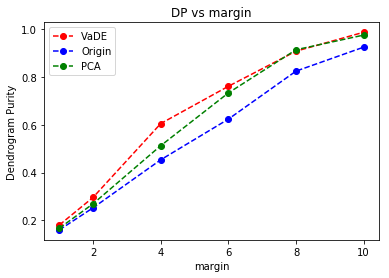

[0.18089058342026304, 0.2967161805843323, 0.6050948835914485, 0.7608827754350481, 0.9076901260025262, 0.9867835914523198]
[0.16063224171441642, 0.2531700396903978, 0.45372590038956573, 0.6236924116965844, 0.824324064074119, 0.9244374213218665]
[0.16776144890760614, 0.26999993552236634, 0.5127450018061996, 0.7332083569182963, 0.9135955389764812, 0.974921892036753]


In [27]:
x = [1,2,4,6,8,10]
y1 = DP
y2 = DP_normal
y3 = DP_pca
plt.plot(x, y1, marker='o', linestyle='--', color='r', label = "VaDE") 
plt.plot(x, y2, marker='o', linestyle='--', color='b', label = "Origin") 
plt.plot(x, y3, marker='o', linestyle='--', color='g', label = "PCA") 
plt.xlabel('margin')
plt.ylabel('Dendrogram Purity') 
plt.title('DP vs margin')
plt.legend()
plt.show()
print(DP)
print(DP_normal)
print(DP_pca)

In [22]:
from sklearn.decomposition import PCA
DP_normal = []
DP_pca = []
for i in x:
    dim = 100
    n_class = 8
    var = 1
    synthetic_data, cla = gen_synthetic(dim, i, n_class, var, 5000)
    perm = np.random.permutation(40000)
    synthetic_data = synthetic_data[perm]
    cla = cla[perm]
    Z_normal = linkage(synthetic_data[:800], "ward")
    DP_normal.append(compute_purity(Z_normal, cla[:800], 8))
    
    pca = PCA(n_components = 10)
    projection = pca.fit_transform(synthetic_data[:800])
    Z = linkage(projection, "ward")
    DP_pca.append(compute_purity(Z, cla[:800], 8))

(40000, 100)
(40000, 100)
(40000, 100)
(40000, 100)
(40000, 100)
(40000, 100)


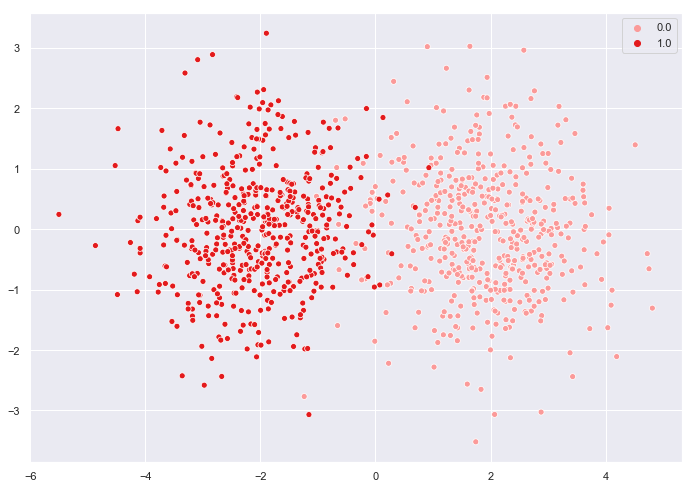

In [344]:
data, data_cla = gen_synthetic(2, 2, 2, 1, 500)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data[:, 0], data[:, 1], hue = np.array(data_cla),  palette = sns.color_palette("Paired", 8)[-4:-2],  legend = "full")
Z = linkage(data, "ward")
rootnode, nodelist = scipy.cluster.hierarchy.to_tree(Z, rd=True)

0.0
0.0
0.3333333333333333
0.5012556504269211


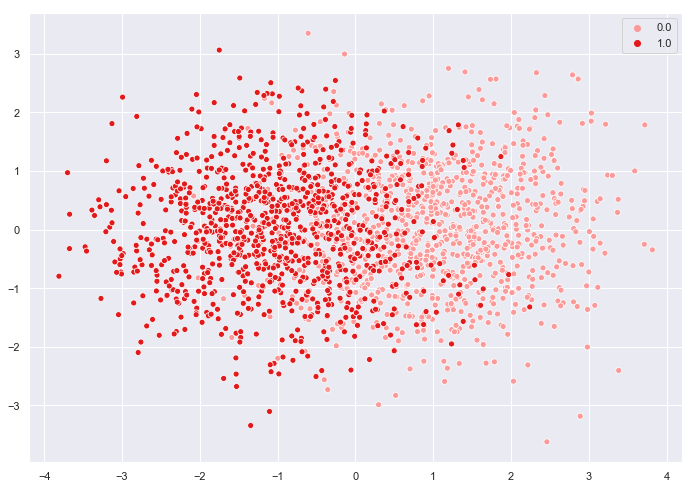

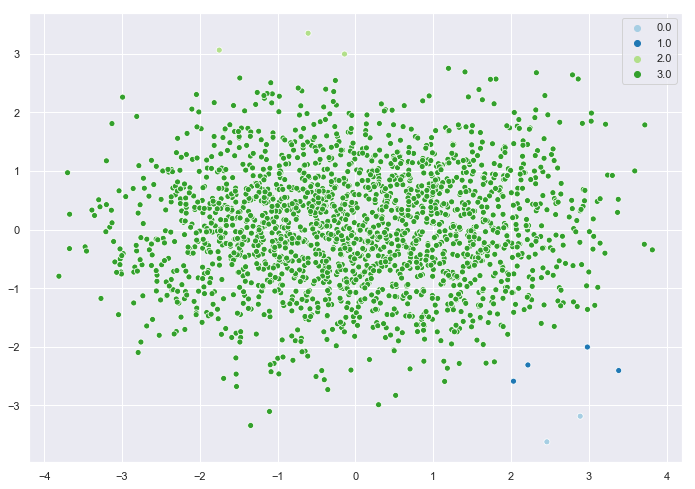

In [247]:
def list_leaves(node):
    if node.is_leaf():
        return [node.id]
    else:
        result = []
        result += list_leaves(node.left)
        result += list_leaves(node.right)
        return result
    
num = 1000
    
data, data_cla = gen_synthetic(2, 1, 2, 1, num)
Z = linkage(data, "average")
rootnode, nodelist = scipy.cluster.hierarchy.to_tree(Z, rd=True)    
"""
leaves_list0 = np.array(list_leaves(rootnode.left.left.left))
print(np.sum(leaves_list0 > 1000) / len(leaves_list0))
leaves_list1 = np.array(list_leaves(rootnode.left.right.left))
print(np.sum(leaves_list1 > 1000) / len(leaves_list1))
leaves_list2 = np.array(list_leaves(rootnode.left.left.right))
print(np.sum(leaves_list2 > 1000) / len(leaves_list2))
leaves_list3 = np.array(list_leaves(rootnode.left.right.right))
print(np.sum(leaves_list3 > 1000) / len(leaves_list3))

leaves_list4 = np.array(list_leaves(rootnode.right.left.right))
print(np.sum(leaves_list4 > 1000) / len(leaves_list4))
leaves_list5 = np.array(list_leaves(rootnode.right.right.left))
print(np.sum(leaves_list5 > 1000) / len(leaves_list5))
leaves_list6 = np.array(list_leaves(rootnode.right.right.right))
print(np.sum(leaves_list6 > 1000) / len(leaves_list6))
leaves_list7 = np.array(list_leaves(rootnode.right.left.left))
print(np.sum(leaves_list7 > 1000) / len(leaves_list7))
"""
leaves_list0 = np.array(list_leaves(rootnode.left.left))
print(np.sum(leaves_list0 > num) / len(leaves_list0))
leaves_list1 = np.array(list_leaves(rootnode.left.right))
print(np.sum(leaves_list1 > num) / len(leaves_list1))
leaves_list2 = np.array(list_leaves(rootnode.right.left))
print(np.sum(leaves_list2 > num) / len(leaves_list2))
leaves_list3 = np.array(list_leaves(rootnode.right.right))
print(np.sum(leaves_list3 > num) / len(leaves_list3))


cla_4 = np.zeros(2 * num)
cla_4[leaves_list0] =0
cla_4[leaves_list1] =1
cla_4[leaves_list2] =2
cla_4[leaves_list3] =3
"""
cla_4[leaves_list4] =4
cla_4[leaves_list5] =5
cla_4[leaves_list6] =6
cla_4[leaves_list7] =7
"""

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data[:, 0], data[:, 1], hue = np.array(data_cla),  palette = sns.color_palette("Paired", 8)[-4:-2],  legend = "full")
plt.show()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data[:, 0], data[:, 1], hue = cla_4,  palette = sns.color_palette("Paired", 4),  legend = "full")
plt.show()


In [227]:
def misclassified_portion(rootnode):
    left_leaves = np.array(list_leaves(rootnode.left))
    right_leaves = np.array(list_leaves(rootnode.right))
    return min((np.sum(left_leaves<1000) + np.sum(right_leaves > 1000)) / 2000, (np.sum(left_leaves>1000) + np.sum(right_leaves < 1000)) / 2000)
def Gaussian_HC(margin, var = 1):
    data, data_cla = gen_synthetic(2, margin, 2, var, 1000)
    Z = linkage(data, "ward")
    rootnode, nodelist = scipy.cluster.hierarchy.to_tree(Z, rd=True)
    return rootnode
result = []
for i in range(100):
    print(i)
    temp = 0
    for j in range(100):
        rootnode = Gaussian_HC(i*4 /100, 1)
        temp += misclassified_portion(rootnode)
    result.append(temp/100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


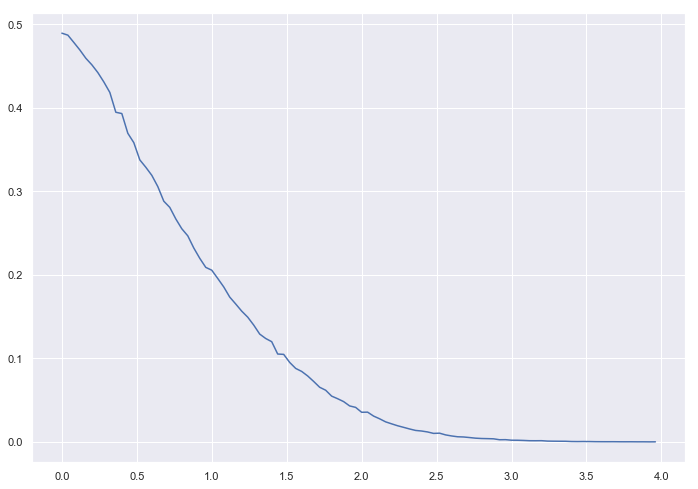

In [228]:
import pickle

plt.plot(np.arange(100) * 4 /100, result)
with open("Synthetic results/2D_Gaussian_vary_margin_ward.pkl", "wb") as f:
    pickle.dump(result, f)


In [382]:
def misclassified_portion(rootnode, n = 1000):
    left_leaves = np.array(list_leaves(rootnode.left))
    right_leaves = np.array(list_leaves(rootnode.right))
    return min((np.sum(left_leaves<n) + np.sum(right_leaves > n)) / (2*n), (np.sum(left_leaves>n) + np.sum(right_leaves < n)) / (2*n))
def Gaussian_HC(margin, var = 1, n = 1000):
    data, data_cla = gen_synthetic(2, margin, 2, var, n)
    Z = linkage(data, "ward")
    rootnode, nodelist = scipy.cluster.hierarchy.to_tree(Z, rd=True)
    return rootnode
result = []
for i in range(50):
    print(i)
    temp = 0
    n = (i+1) * 100
    for j in range(50):
        rootnode = Gaussian_HC(1, 1, n)
        temp += misclassified_portion(rootnode, n)
    result.append(temp/50)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


KeyboardInterrupt: 

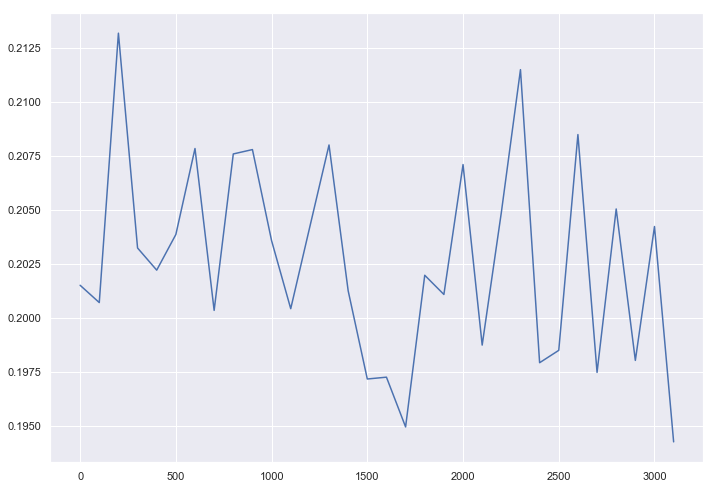

In [383]:
plt.plot(np.arange(32) * 100, result) 

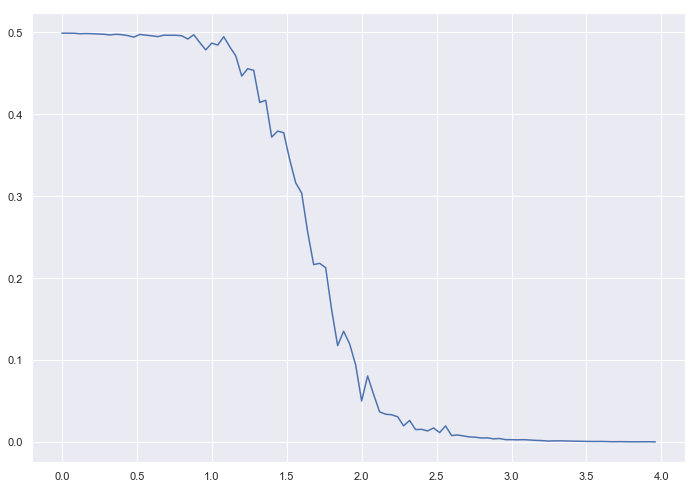

In [230]:
with open("Synthetic results/2D_Gaussian_vary_margin_average.pkl", "rb") as f:
    result_complete = pickle.load(f)
plt.plot(np.arange(100) * 4 /100, result_complete)  

In [51]:
DP = []
for i in [3, 10, 50, 100, 200, 500]:
    DP.append(run_experiments(4, i))


  0%|          | 0/10 [00:00<?, ?it/s]

(40000, 3)
Pretraining......


                                      
 10%|█         | 1/10 [00:00<00:07,  1.25it/s]

L2=0.9448


                                      
 20%|██        | 2/10 [00:01<00:06,  1.25it/s]

L2=0.0029


                                      
 30%|███       | 3/10 [00:02<00:05,  1.23it/s]

L2=0.0018


                                      
 40%|████      | 4/10 [00:03<00:04,  1.21it/s]

L2=0.0014


                                      
 50%|█████     | 5/10 [00:04<00:04,  1.21it/s]

L2=0.0015


                                      
 60%|██████    | 6/10 [00:04<00:03,  1.20it/s]

L2=0.0011


                                      
 70%|███████   | 7/10 [00:05<00:02,  1.20it/s]

L2=0.0013


                                      
 80%|████████  | 8/10 [00:06<00:01,  1.19it/s]

L2=0.0011


                                      
 90%|█████████ | 9/10 [00:07<00:00,  1.12it/s]

L2=0.0011


                                      
100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


L2=0.0010



  0%|          | 0/50 [00:00<?, ?it/s]

272.9134459543228



  2%|▏         | 1/50 [00:11<09:14, 11.31s/it]

19.749327585697174



  4%|▍         | 2/50 [00:23<09:08, 11.43s/it]

15.543820095062255



  6%|▌         | 3/50 [00:34<08:55, 11.39s/it]

13.766354484558105



  8%|▊         | 4/50 [00:43<08:15, 10.78s/it]

12.612378530502319



 10%|█         | 5/50 [00:53<07:54, 10.54s/it]

11.615779316425323



 12%|█▏        | 6/50 [01:03<07:30, 10.24s/it]

10.104868021011352



 14%|█▍        | 7/50 [01:11<06:54,  9.65s/it]

8.922167735099793



 16%|█▌        | 8/50 [01:20<06:32,  9.33s/it]

8.236931978464126



 18%|█▊        | 9/50 [01:28<06:09,  9.00s/it]

7.568809428215027



 20%|██        | 10/50 [01:36<05:46,  8.66s/it]

6.729406675100327



 22%|██▏       | 11/50 [01:43<05:19,  8.20s/it]

5.601161439418792



 24%|██▍       | 12/50 [01:49<04:52,  7.71s/it]

4.7579404532909395



 26%|██▌       | 13/50 [01:56<04:28,  7.25s/it]

4.263804914355278



 28%|██▊       | 14/50 [02:02<04:13,  7.04s/it]

3.8026131302118302



 30%|███       | 15/50 [02:09<04:00,  6.89s/it]

3.3802606308460237



 32%|███▏      | 16/50 [02:15<03:51,  6.82s/it]

2.963074033856392



 34%|███▍      | 17/50 [02:22<03:42,  6.73s/it]

2.5427576899528503



 36%|███▌      | 18/50 [02:28<03:29,  6.56s/it]

2.1231653368473054



 38%|███▊      | 19/50 [02:34<03:19,  6.44s/it]

1.7127843022346496



 40%|████      | 20/50 [02:40<03:10,  6.35s/it]

1.2940510684251785



 42%|████▏     | 21/50 [02:47<03:05,  6.39s/it]

0.8650222587585449



 44%|████▍     | 22/50 [02:53<02:58,  6.37s/it]

0.42551401495933533



 46%|████▌     | 23/50 [02:59<02:51,  6.36s/it]

-0.02229703903198242



 48%|████▊     | 24/50 [03:06<02:46,  6.39s/it]

-0.4655859529972076



 50%|█████     | 25/50 [03:13<02:43,  6.52s/it]

-0.9102156555652618



 52%|█████▏    | 26/50 [03:20<02:38,  6.62s/it]

-1.3358422410488129



 54%|█████▍    | 27/50 [03:26<02:34,  6.70s/it]

-1.7806757235527038



 56%|█████▌    | 28/50 [03:33<02:28,  6.76s/it]

-2.2356223893165588



 58%|█████▊    | 29/50 [03:40<02:22,  6.80s/it]

-2.6459460163116457



 60%|██████    | 30/50 [03:47<02:16,  6.84s/it]

-3.101210632324219



 62%|██████▏   | 31/50 [03:54<02:09,  6.80s/it]

-3.5330842328071594



 64%|██████▍   | 32/50 [04:00<02:01,  6.75s/it]

-3.9765116000175476



 66%|██████▌   | 33/50 [04:07<01:53,  6.66s/it]

-4.4169394135475155



 68%|██████▊   | 34/50 [04:13<01:45,  6.62s/it]

-4.846132218837738



 70%|███████   | 35/50 [04:20<01:39,  6.65s/it]

-5.272115335464478



 72%|███████▏  | 36/50 [04:27<01:32,  6.62s/it]

-5.705311450958252



 74%|███████▍  | 37/50 [04:33<01:25,  6.60s/it]

-6.139105167388916



 76%|███████▌  | 38/50 [04:40<01:19,  6.59s/it]

-6.554796240329742



 78%|███████▊  | 39/50 [04:47<01:12,  6.61s/it]

-6.991053819656372



 80%|████████  | 40/50 [04:53<01:05,  6.58s/it]

-7.414664702415466



 82%|████████▏ | 41/50 [05:00<00:58,  6.55s/it]

-7.8476463055610655



 84%|████████▍ | 42/50 [05:06<00:52,  6.52s/it]

-8.2685471534729



 86%|████████▌ | 43/50 [05:12<00:45,  6.51s/it]

-8.69746747970581



 88%|████████▊ | 44/50 [05:19<00:39,  6.55s/it]

-9.1007049202919



 90%|█████████ | 45/50 [05:26<00:32,  6.52s/it]

-9.537645711898804



 92%|█████████▏| 46/50 [05:32<00:26,  6.57s/it]

-9.958960707187652



 94%|█████████▍| 47/50 [05:39<00:19,  6.62s/it]

-10.372669692039489



 96%|█████████▌| 48/50 [05:45<00:13,  6.59s/it]

-10.791124098300934



 98%|█████████▊| 49/50 [05:52<00:06,  6.59s/it]

-11.1949880027771



100%|██████████| 50/50 [05:59<00:00,  7.18s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

(40000, 10)
Pretraining......



                                      
 10%|█         | 1/10 [00:00<00:07,  1.23it/s]

L2=0.9118



                                              
 20%|██        | 2/10 [00:01<00:06,  1.23it/s]

L2=0.4019



                                              
 30%|███       | 3/10 [00:02<00:05,  1.22it/s]

L2=0.1965



                                              
 40%|████      | 4/10 [00:03<00:04,  1.20it/s]

L2=0.1060



                                              
 50%|█████     | 5/10 [00:04<00:04,  1.19it/s]

L2=0.0108



                                              
 60%|██████    | 6/10 [00:05<00:03,  1.19it/s]

L2=0.0048



                                              
 70%|███████   | 7/10 [00:05<00:02,  1.16it/s]

L2=0.0040



                                              
 80%|████████  | 8/10 [00:06<00:01,  1.16it/s]

L2=0.0033



                                              
 90%|█████████ | 9/10 [00:07<00:00,  1.16it/s]

L2=0.0029



                                              
100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


L2=0.0028



  0%|          | 0/50 [00:00<?, ?it/s]

86.0885467004776



  2%|▏         | 1/50 [00:09<07:50,  9.60s/it]

24.638789138793946



  4%|▍         | 2/50 [00:18<07:32,  9.43s/it]

21.457209420204162



  6%|▌         | 3/50 [00:27<07:19,  9.34s/it]

19.854657917022706



  8%|▊         | 4/50 [00:36<07:08,  9.31s/it]

18.853241143226622



 10%|█         | 5/50 [00:46<06:55,  9.24s/it]

18.128683047294615



 12%|█▏        | 6/50 [00:55<06:42,  9.16s/it]

17.599119668006896



 14%|█▍        | 7/50 [01:03<06:30,  9.08s/it]

17.043388421535493



 16%|█▌        | 8/50 [01:13<06:21,  9.08s/it]

16.56864273071289



 18%|█▊        | 9/50 [01:22<06:12,  9.08s/it]

16.087657096385957



 20%|██        | 10/50 [01:31<06:03,  9.09s/it]

15.6059099316597



 22%|██▏       | 11/50 [01:40<05:53,  9.06s/it]

15.170406863689422



 24%|██▍       | 12/50 [01:48<05:40,  8.95s/it]

14.707423858642578



 26%|██▌       | 13/50 [01:57<05:31,  8.96s/it]

14.21306815624237



 28%|██▊       | 14/50 [02:06<05:22,  8.97s/it]

13.739964845180511



 30%|███       | 15/50 [02:15<05:12,  8.93s/it]

13.245183942317963



 32%|███▏      | 16/50 [02:24<05:02,  8.89s/it]

12.69406519651413



 34%|███▍      | 17/50 [02:32<04:49,  8.76s/it]

11.974979355335236



 36%|███▌      | 18/50 [02:41<04:35,  8.62s/it]

11.279528529644013



 38%|███▊      | 19/50 [02:48<04:15,  8.24s/it]

10.619670734405517



 40%|████      | 20/50 [02:55<03:54,  7.81s/it]

9.994068994522095



 42%|████▏     | 21/50 [03:01<03:33,  7.35s/it]

9.413008284568786



 44%|████▍     | 22/50 [03:08<03:18,  7.09s/it]

8.902520436048508



 46%|████▌     | 23/50 [03:14<03:04,  6.85s/it]

8.422873418331147



 48%|████▊     | 24/50 [03:20<02:53,  6.68s/it]

7.946743806600571



 50%|█████     | 25/50 [03:27<02:43,  6.55s/it]

7.4796206772327425



 52%|█████▏    | 26/50 [03:33<02:34,  6.44s/it]

7.0233980762958526



 54%|█████▍    | 27/50 [03:39<02:27,  6.41s/it]

6.59673305273056



 56%|█████▌    | 28/50 [03:46<02:23,  6.52s/it]

6.162720990180969



 58%|█████▊    | 29/50 [03:52<02:14,  6.42s/it]

5.721810612678528



 60%|██████    | 30/50 [03:58<02:07,  6.39s/it]

5.317009422779083



 62%|██████▏   | 31/50 [04:05<02:04,  6.54s/it]

4.893975667953491



 64%|██████▍   | 32/50 [04:11<01:55,  6.44s/it]

4.476738841533661



 66%|██████▌   | 33/50 [04:18<01:48,  6.38s/it]

4.0533976244926455



 68%|██████▊   | 34/50 [04:24<01:42,  6.40s/it]

3.6164498937129976



 70%|███████   | 35/50 [04:30<01:35,  6.34s/it]

3.202628570795059



 72%|███████▏  | 36/50 [04:37<01:28,  6.34s/it]

2.796410413980484



 74%|███████▍  | 37/50 [04:43<01:21,  6.30s/it]

2.3539565229415893



 76%|███████▌  | 38/50 [04:49<01:15,  6.31s/it]

1.9515063655376435



 78%|███████▊  | 39/50 [04:55<01:09,  6.30s/it]

1.536194989681244



 80%|████████  | 40/50 [05:02<01:02,  6.29s/it]

1.1105116677284241



 82%|████████▏ | 41/50 [05:08<00:57,  6.36s/it]

0.6920110845565796



 84%|████████▍ | 42/50 [05:15<00:51,  6.42s/it]

0.29883829832077025



 86%|████████▌ | 43/50 [05:21<00:44,  6.33s/it]

-0.1278531050682068



 88%|████████▊ | 44/50 [05:27<00:38,  6.36s/it]

-0.5330620908737183



 90%|█████████ | 45/50 [05:34<00:31,  6.34s/it]

-0.9498105764389038



 92%|█████████▏| 46/50 [05:40<00:25,  6.37s/it]

-1.333144679069519



 94%|█████████▍| 47/50 [05:46<00:19,  6.35s/it]

-1.758750340938568



 96%|█████████▌| 48/50 [05:53<00:12,  6.47s/it]

-2.170497238636017



 98%|█████████▊| 49/50 [05:59<00:06,  6.43s/it]

-2.5832705307006836



100%|██████████| 50/50 [06:06<00:00,  7.33s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

(40000, 50)
Pretraining......



                                      
 10%|█         | 1/10 [00:01<00:09,  1.01s/it]

L2=1.0313



                                              
 20%|██        | 2/10 [00:02<00:08,  1.02s/it]

L2=0.8894



                                              
 30%|███       | 3/10 [00:02<00:06,  1.00it/s]

L2=0.8308



                                              
 40%|████      | 4/10 [00:03<00:05,  1.03it/s]

L2=0.8219



                                              
 50%|█████     | 5/10 [00:04<00:04,  1.04it/s]

L2=0.8053



                                              
 60%|██████    | 6/10 [00:05<00:03,  1.05it/s]

L2=0.7994



                                              
 70%|███████   | 7/10 [00:06<00:02,  1.06it/s]

L2=0.7978



                                              
 80%|████████  | 8/10 [00:07<00:01,  1.07it/s]

L2=0.7966



                                              
 90%|█████████ | 9/10 [00:08<00:00,  1.07it/s]

L2=0.7954



                                              
100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


L2=0.7937



  0%|          | 0/50 [00:00<?, ?it/s]

74.43060307502746



  2%|▏         | 1/50 [00:07<05:44,  7.02s/it]

56.3070396232605



  4%|▍         | 2/50 [00:13<05:33,  6.95s/it]

54.98883527755737



  6%|▌         | 3/50 [00:21<05:30,  7.03s/it]

54.18529863357544



  8%|▊         | 4/50 [00:28<05:24,  7.06s/it]

53.48250098228455



 10%|█         | 5/50 [00:35<05:17,  7.05s/it]

52.86702424049378



 12%|█▏        | 6/50 [00:42<05:07,  6.99s/it]

52.26660490036011



 14%|█▍        | 7/50 [00:48<04:57,  6.93s/it]

51.6737028503418



 16%|█▌        | 8/50 [00:55<04:47,  6.85s/it]

51.14794550895691



 18%|█▊        | 9/50 [01:02<04:39,  6.82s/it]

50.59167897224426



 20%|██        | 10/50 [01:09<04:35,  6.89s/it]

50.06312821388244



 22%|██▏       | 11/50 [01:16<04:26,  6.84s/it]

49.54285136222839



 24%|██▍       | 12/50 [01:22<04:18,  6.81s/it]

49.05889503479004



 26%|██▌       | 13/50 [01:29<04:12,  6.83s/it]

48.56314571380615



 28%|██▊       | 14/50 [01:36<04:02,  6.73s/it]

48.067917594909666



 30%|███       | 15/50 [01:42<03:53,  6.67s/it]

47.56514280319214



 32%|███▏      | 16/50 [01:49<03:45,  6.63s/it]

47.11905110359192



 34%|███▍      | 17/50 [01:55<03:36,  6.58s/it]

46.637512798309324



 36%|███▌      | 18/50 [02:02<03:29,  6.54s/it]

46.175562057495114



 38%|███▊      | 19/50 [02:08<03:22,  6.54s/it]

45.70734447479248



 40%|████      | 20/50 [02:15<03:15,  6.52s/it]

45.252860431671145



 42%|████▏     | 21/50 [02:21<03:08,  6.51s/it]

44.76644311904907



 44%|████▍     | 22/50 [02:28<03:03,  6.55s/it]

44.316411838531494



 46%|████▌     | 23/50 [02:34<02:56,  6.53s/it]

43.854259672164915



 48%|████▊     | 24/50 [02:41<02:48,  6.46s/it]

43.40257565498352



 50%|█████     | 25/50 [02:47<02:41,  6.48s/it]

42.9839142036438



 52%|█████▏    | 26/50 [02:54<02:39,  6.66s/it]

42.533929395675656



 54%|█████▍    | 27/50 [03:01<02:35,  6.74s/it]

42.06845788002014



 56%|█████▌    | 28/50 [03:08<02:28,  6.76s/it]

41.636707315444944



 58%|█████▊    | 29/50 [03:14<02:20,  6.70s/it]

41.20685576438904



 60%|██████    | 30/50 [03:21<02:14,  6.70s/it]

40.759136819839476



 62%|██████▏   | 31/50 [03:28<02:07,  6.71s/it]

40.33755464553833



 64%|██████▍   | 32/50 [03:34<01:59,  6.65s/it]

39.89567801475525



 66%|██████▌   | 33/50 [03:41<01:51,  6.59s/it]

39.48764715194702



 68%|██████▊   | 34/50 [03:47<01:44,  6.56s/it]

39.06937479019165



 70%|███████   | 35/50 [03:54<01:37,  6.50s/it]

38.640271492004395



 72%|███████▏  | 36/50 [04:00<01:31,  6.51s/it]

38.22133604049682



 74%|███████▍  | 37/50 [04:07<01:25,  6.56s/it]

37.79805693626404



 76%|███████▌  | 38/50 [04:14<01:19,  6.66s/it]

37.36920007705689



 78%|███████▊  | 39/50 [04:20<01:13,  6.68s/it]

36.9834992313385



 80%|████████  | 40/50 [04:27<01:06,  6.65s/it]

36.55121380805969



 82%|████████▏ | 41/50 [04:34<01:00,  6.69s/it]

36.12296807289123



 84%|████████▍ | 42/50 [04:41<00:53,  6.69s/it]

35.742877836227414



 86%|████████▌ | 43/50 [04:47<00:46,  6.63s/it]

35.32094895362854



 88%|████████▊ | 44/50 [04:53<00:39,  6.54s/it]

34.89416890144348



 90%|█████████ | 45/50 [05:00<00:32,  6.50s/it]

34.48003607749939



 92%|█████████▏| 46/50 [05:06<00:25,  6.46s/it]

34.06796989440918



 94%|█████████▍| 47/50 [05:13<00:19,  6.45s/it]

33.685086636543275



 96%|█████████▌| 48/50 [05:19<00:12,  6.43s/it]

33.27719578742981



 98%|█████████▊| 49/50 [05:25<00:06,  6.45s/it]

32.85615931034088



100%|██████████| 50/50 [05:32<00:00,  6.65s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

(40000, 100)
Pretraining......



                                      
 10%|█         | 1/10 [00:00<00:08,  1.10it/s]

L2=1.0220



                                              
 20%|██        | 2/10 [00:01<00:07,  1.09it/s]

L2=0.9372



                                              
 30%|███       | 3/10 [00:02<00:06,  1.07it/s]

L2=0.9113



                                              
 40%|████      | 4/10 [00:03<00:05,  1.03it/s]

L2=0.9016



                                              
 50%|█████     | 5/10 [00:04<00:04,  1.01it/s]

L2=0.8995



                                              
 60%|██████    | 6/10 [00:05<00:04,  1.00s/it]

L2=0.8981



                                              
 70%|███████   | 7/10 [00:06<00:03,  1.01s/it]

L2=0.8968



                                              
 80%|████████  | 8/10 [00:07<00:02,  1.01s/it]

L2=0.8956



                                              
 90%|█████████ | 9/10 [00:09<00:01,  1.02s/it]

L2=0.8947



                                              
100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


L2=0.8937



  0%|          | 0/50 [00:00<?, ?it/s]

110.63506521224976



  2%|▏         | 1/50 [00:07<06:03,  7.41s/it]

103.97767417907716



  4%|▍         | 2/50 [00:15<06:01,  7.53s/it]

102.9492419052124



  6%|▌         | 3/50 [00:23<06:01,  7.70s/it]

102.16480768203735



  8%|▊         | 4/50 [00:30<05:42,  7.45s/it]

101.52920915603637



 10%|█         | 5/50 [00:37<05:31,  7.38s/it]

100.9029832649231



 12%|█▏        | 6/50 [00:44<05:18,  7.24s/it]

100.32120700836181



 14%|█▍        | 7/50 [00:51<05:05,  7.11s/it]

99.76953733444213



 16%|█▌        | 8/50 [00:58<04:58,  7.10s/it]

99.21729188919068



 18%|█▊        | 9/50 [01:05<04:51,  7.12s/it]

98.68893058776855



 20%|██        | 10/50 [01:12<04:39,  6.99s/it]

98.12063461303711



 22%|██▏       | 11/50 [01:18<04:29,  6.90s/it]

97.63655462265015



 24%|██▍       | 12/50 [01:25<04:22,  6.91s/it]

97.13585577011108



 26%|██▌       | 13/50 [01:32<04:16,  6.93s/it]

96.65314386367798



 28%|██▊       | 14/50 [01:39<04:08,  6.90s/it]

96.18331979751586



 30%|███       | 15/50 [01:46<04:04,  6.99s/it]

95.67705884933471



 32%|███▏      | 16/50 [01:53<03:53,  6.87s/it]

95.21321096420289



 34%|███▍      | 17/50 [01:59<03:45,  6.83s/it]

94.73772857666016



 36%|███▌      | 18/50 [02:06<03:35,  6.73s/it]

94.2874125289917



 38%|███▊      | 19/50 [02:13<03:27,  6.69s/it]

93.84807304382325



 40%|████      | 20/50 [02:19<03:21,  6.72s/it]

93.35671541213989



 42%|████▏     | 21/50 [02:26<03:14,  6.72s/it]

92.92142576217651



 44%|████▍     | 22/50 [02:33<03:06,  6.65s/it]

92.49005088806152



 46%|████▌     | 23/50 [02:39<02:57,  6.58s/it]

92.06689682006837



 48%|████▊     | 24/50 [02:46<02:51,  6.60s/it]

91.64053289413452



 50%|█████     | 25/50 [02:52<02:44,  6.57s/it]

91.18490718841552



 52%|█████▏    | 26/50 [02:59<02:36,  6.54s/it]

90.76876310348511



 54%|█████▍    | 27/50 [03:05<02:30,  6.53s/it]

90.3291124534607



 56%|█████▌    | 28/50 [03:12<02:23,  6.52s/it]

89.88561473846435



 58%|█████▊    | 29/50 [03:18<02:17,  6.56s/it]

89.48422618865966



 60%|██████    | 30/50 [03:25<02:11,  6.56s/it]

89.04802879333496



 62%|██████▏   | 31/50 [03:31<02:04,  6.55s/it]

88.62991922378541



 64%|██████▍   | 32/50 [03:38<01:57,  6.51s/it]

88.20182191848755



 66%|██████▌   | 33/50 [03:44<01:50,  6.50s/it]

87.78953638076783



 68%|██████▊   | 34/50 [03:51<01:44,  6.50s/it]

87.34857318878174



 70%|███████   | 35/50 [03:57<01:38,  6.57s/it]

86.92511478424072



 72%|███████▏  | 36/50 [04:04<01:31,  6.54s/it]

86.54372734069824



 74%|███████▍  | 37/50 [04:10<01:24,  6.52s/it]

86.10339933395386



 76%|███████▌  | 38/50 [04:17<01:18,  6.51s/it]

85.68131206512452



 78%|███████▊  | 39/50 [04:23<01:11,  6.46s/it]

85.30170907974244



 80%|████████  | 40/50 [04:30<01:04,  6.45s/it]

84.86094158172608



 82%|████████▏ | 41/50 [04:36<00:58,  6.45s/it]

84.4527917289734



 84%|████████▍ | 42/50 [04:43<00:51,  6.44s/it]

84.02075229644775



 86%|████████▌ | 43/50 [04:49<00:45,  6.45s/it]

83.60237300872802



 88%|████████▊ | 44/50 [04:56<00:38,  6.46s/it]

83.21262315750123



 90%|█████████ | 45/50 [05:02<00:32,  6.44s/it]

82.79055053710937



 92%|█████████▏| 46/50 [05:08<00:25,  6.41s/it]

82.37543474197388



 94%|█████████▍| 47/50 [05:15<00:19,  6.42s/it]

81.98849931716919



 96%|█████████▌| 48/50 [05:21<00:12,  6.40s/it]

81.56661697387695



 98%|█████████▊| 49/50 [05:27<00:06,  6.40s/it]

81.17836364746094



100%|██████████| 50/50 [05:34<00:00,  6.69s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

(40000, 200)
Pretraining......



                                      
 10%|█         | 1/10 [00:00<00:08,  1.00it/s]

L2=1.0047



                                              
 20%|██        | 2/10 [00:02<00:08,  1.00s/it]

L2=0.9632



                                              
 30%|███       | 3/10 [00:03<00:07,  1.04s/it]

L2=0.9554



                                              
 40%|████      | 4/10 [00:04<00:06,  1.07s/it]

L2=0.9501



                                              
 50%|█████     | 5/10 [00:05<00:05,  1.09s/it]

L2=0.9486



                                              
 60%|██████    | 6/10 [00:06<00:04,  1.11s/it]

L2=0.9477



                                              
 70%|███████   | 7/10 [00:07<00:03,  1.12s/it]

L2=0.9469



                                              
 80%|████████  | 8/10 [00:08<00:02,  1.13s/it]

L2=0.9462



                                              
 90%|█████████ | 9/10 [00:10<00:01,  1.14s/it]

L2=0.9456



                                              
100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


L2=0.9450



  0%|          | 0/50 [00:00<?, ?it/s]

211.1143821334839



  2%|▏         | 1/50 [00:07<05:44,  7.02s/it]

204.30233791351318



  4%|▍         | 2/50 [00:13<05:33,  6.95s/it]

203.11775604248047



  6%|▌         | 3/50 [00:20<05:25,  6.93s/it]

202.31920364379883



  8%|▊         | 4/50 [00:27<05:22,  7.01s/it]

201.63670360565186



 10%|█         | 5/50 [00:34<05:12,  6.94s/it]

200.98975719451903



 12%|█▏        | 6/50 [00:41<05:01,  6.86s/it]

200.44632331848143



 14%|█▍        | 7/50 [00:47<04:51,  6.78s/it]

199.88315216064453



 16%|█▌        | 8/50 [00:54<04:42,  6.73s/it]

199.32805019378662



 18%|█▊        | 9/50 [01:01<04:37,  6.76s/it]

198.81332611083985



 20%|██        | 10/50 [01:07<04:27,  6.68s/it]

198.32301593780517



 22%|██▏       | 11/50 [01:14<04:18,  6.64s/it]

197.81556148529052



 24%|██▍       | 12/50 [01:21<04:12,  6.63s/it]

197.34887851715087



 26%|██▌       | 13/50 [01:27<04:04,  6.61s/it]

196.8720392227173



 28%|██▊       | 14/50 [01:34<03:56,  6.58s/it]

196.35103672027589



 30%|███       | 15/50 [01:40<03:49,  6.55s/it]

195.88033397674562



 32%|███▏      | 16/50 [01:47<03:46,  6.67s/it]

195.4264345550537



 34%|███▍      | 17/50 [01:54<03:40,  6.69s/it]

194.9584167098999



 36%|███▌      | 18/50 [02:00<03:31,  6.61s/it]

194.50458560943605



 38%|███▊      | 19/50 [02:06<03:21,  6.51s/it]

194.03897186279298



 40%|████      | 20/50 [02:13<03:14,  6.49s/it]

193.6023711013794



 42%|████▏     | 21/50 [02:19<03:07,  6.45s/it]

193.1466008758545



 44%|████▍     | 22/50 [02:26<02:59,  6.41s/it]

192.6816003036499



 46%|████▌     | 23/50 [02:32<02:52,  6.38s/it]

192.2654253387451



 48%|████▊     | 24/50 [02:38<02:46,  6.39s/it]

191.82235233306884



 50%|█████     | 25/50 [02:45<02:39,  6.38s/it]

191.3920475769043



 52%|█████▏    | 26/50 [02:51<02:32,  6.37s/it]

190.953099899292



 54%|█████▍    | 27/50 [02:58<02:28,  6.43s/it]

190.49184692382812



 56%|█████▌    | 28/50 [03:04<02:22,  6.48s/it]

190.0843494796753



 58%|█████▊    | 29/50 [03:11<02:15,  6.47s/it]

189.6738748550415



 60%|██████    | 30/50 [03:17<02:09,  6.46s/it]

189.2417258453369



 62%|██████▏   | 31/50 [03:24<02:02,  6.46s/it]

188.7974108505249



 64%|██████▍   | 32/50 [03:30<01:56,  6.46s/it]

188.38450931549073



 66%|██████▌   | 33/50 [03:36<01:49,  6.43s/it]

187.97956336975096



 68%|██████▊   | 34/50 [03:43<01:42,  6.41s/it]

187.5325617980957



 70%|███████   | 35/50 [03:49<01:35,  6.39s/it]

187.1176202774048



 72%|███████▏  | 36/50 [03:55<01:29,  6.41s/it]

186.70918037414552



 74%|███████▍  | 37/50 [04:02<01:23,  6.42s/it]

186.2638838195801



 76%|███████▌  | 38/50 [04:08<01:16,  6.40s/it]

185.8773494720459



 78%|███████▊  | 39/50 [04:15<01:10,  6.41s/it]

185.4584895324707



 80%|████████  | 40/50 [04:21<01:03,  6.37s/it]

185.02023780822753



 82%|████████▏ | 41/50 [04:27<00:57,  6.38s/it]

184.62219562530518



 84%|████████▍ | 42/50 [04:34<00:51,  6.40s/it]

184.21774333953857



 86%|████████▌ | 43/50 [04:40<00:44,  6.38s/it]

183.7904123687744



 88%|████████▊ | 44/50 [04:47<00:38,  6.41s/it]

183.40179527282714



 90%|█████████ | 45/50 [04:53<00:32,  6.42s/it]

182.98511157989503



 92%|█████████▏| 46/50 [05:00<00:25,  6.44s/it]

182.56730575561522



 94%|█████████▍| 47/50 [05:06<00:19,  6.43s/it]

182.14845985412597



 96%|█████████▌| 48/50 [05:12<00:12,  6.41s/it]

181.74426151275634



 98%|█████████▊| 49/50 [05:19<00:06,  6.42s/it]

181.33757598876954



100%|██████████| 50/50 [05:25<00:00,  6.52s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

(40000, 500)
Pretraining......


                                      
 10%|█         | 1/10 [00:01<00:11,  1.25s/it]

L2=1.0060


                                      
 20%|██        | 2/10 [00:02<00:10,  1.25s/it]

L2=0.9890


                                      
 30%|███       | 3/10 [00:03<00:09,  1.31s/it]

L2=0.9825


                                      
 40%|████      | 4/10 [00:05<00:08,  1.38s/it]

L2=0.9800


                                      
 50%|█████     | 5/10 [00:07<00:07,  1.43s/it]

L2=0.9790


                                      
 60%|██████    | 6/10 [00:08<00:05,  1.46s/it]

L2=0.9783


                                      
 70%|███████   | 7/10 [00:10<00:04,  1.48s/it]

L2=0.9777


                                      
 80%|████████  | 8/10 [00:11<00:02,  1.50s/it]

L2=0.9773


                                      
 90%|█████████ | 9/10 [00:13<00:01,  1.51s/it]

L2=0.9769


                                      
100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


L2=0.9765



  0%|          | 0/50 [00:00<?, ?it/s]

509.9748769378662



  2%|▏         | 1/50 [00:07<05:43,  7.01s/it]

501.87880783081056



  4%|▍         | 2/50 [00:13<05:34,  6.96s/it]

500.8744385528564



  6%|▌         | 3/50 [00:20<05:26,  6.95s/it]

500.15912033081054



  8%|▊         | 4/50 [00:27<05:23,  7.02s/it]

499.51183891296387



 10%|█         | 5/50 [00:34<05:15,  7.02s/it]

498.96028076171876



 12%|█▏        | 6/50 [00:41<05:07,  6.99s/it]

498.3888349151611



 14%|█▍        | 7/50 [00:48<05:00,  7.00s/it]

497.8514782714844



 16%|█▌        | 8/50 [00:55<04:54,  7.01s/it]

497.3600841522217



 18%|█▊        | 9/50 [01:02<04:47,  7.00s/it]

496.84488288879396



 20%|██        | 10/50 [01:09<04:40,  7.01s/it]

496.3543467712402



 22%|██▏       | 11/50 [01:16<04:33,  7.00s/it]

495.85172828674314



 24%|██▍       | 12/50 [01:24<04:28,  7.05s/it]

495.36722526550295



 26%|██▌       | 13/50 [01:31<04:22,  7.09s/it]

494.8540386962891



 28%|██▊       | 14/50 [01:38<04:14,  7.07s/it]

494.3731121063232



 30%|███       | 15/50 [01:45<04:05,  7.01s/it]

493.9038995361328



 32%|███▏      | 16/50 [01:52<03:56,  6.96s/it]

493.40967712402346



 34%|███▍      | 17/50 [01:58<03:48,  6.93s/it]

492.93383506774904



 36%|███▌      | 18/50 [02:05<03:41,  6.91s/it]

492.47301361083987



 38%|███▊      | 19/50 [02:12<03:34,  6.92s/it]

492.01687995910646



 40%|████      | 20/50 [02:19<03:27,  6.92s/it]

491.54494544982913



 42%|████▏     | 21/50 [02:26<03:20,  6.90s/it]

491.0996424865723



 44%|████▍     | 22/50 [02:33<03:14,  6.93s/it]

490.65228805541994



 46%|████▌     | 23/50 [02:40<03:06,  6.93s/it]

490.1994879150391



 48%|████▊     | 24/50 [02:47<02:59,  6.92s/it]

489.75968215942385



 50%|█████     | 25/50 [02:54<02:52,  6.91s/it]

489.31626708984373



 52%|█████▏    | 26/50 [03:01<02:45,  6.89s/it]

488.8604443359375



 54%|█████▍    | 27/50 [03:08<02:39,  6.93s/it]

488.4307402801514



 56%|█████▌    | 28/50 [03:15<02:34,  7.01s/it]

488.00795166015627



 58%|█████▊    | 29/50 [03:22<02:26,  7.00s/it]

487.5649872589111



 60%|██████    | 30/50 [03:29<02:21,  7.09s/it]

487.1497176361084



 62%|██████▏   | 31/50 [03:36<02:16,  7.19s/it]

486.72655784606934



 64%|██████▍   | 32/50 [03:44<02:08,  7.16s/it]

486.2934384918213



 66%|██████▌   | 33/50 [03:51<02:00,  7.12s/it]

485.86715461730955



 68%|██████▊   | 34/50 [03:58<01:53,  7.09s/it]

485.4441371154785



 70%|███████   | 35/50 [04:05<01:46,  7.07s/it]

485.00854286193845



 72%|███████▏  | 36/50 [04:12<01:38,  7.06s/it]

484.60430114746094



 74%|███████▍  | 37/50 [04:19<01:31,  7.05s/it]

484.184646987915



 76%|███████▌  | 38/50 [04:26<01:24,  7.01s/it]

483.77506286621093



 78%|███████▊  | 39/50 [04:33<01:16,  6.99s/it]

483.3634958648682



 80%|████████  | 40/50 [04:40<01:09,  6.99s/it]

482.9545938873291



 82%|████████▏ | 41/50 [04:47<01:02,  6.99s/it]

482.5154376983643



 84%|████████▍ | 42/50 [04:53<00:55,  6.93s/it]

482.10828063964846



 86%|████████▌ | 43/50 [05:00<00:48,  6.95s/it]

481.6949035644531



 88%|████████▊ | 44/50 [05:07<00:41,  6.93s/it]

481.3034519958496



 90%|█████████ | 45/50 [05:14<00:34,  6.90s/it]

480.89110260009767



 92%|█████████▏| 46/50 [05:21<00:27,  6.93s/it]

480.5214009857178



 94%|█████████▍| 47/50 [05:28<00:20,  6.93s/it]

480.10941139221194



 96%|█████████▌| 48/50 [05:35<00:13,  6.94s/it]

479.7074177551269



 98%|█████████▊| 49/50 [05:42<00:06,  6.94s/it]

479.2574517059326



100%|██████████| 50/50 [05:49<00:00,  6.99s/it]


In [142]:
data, data_cla = gen_synthetic(2, 2, 2, 1, 1000)
np.mean(data[1000:], axis = 0)

array([-1.95397420e+00, -3.44677382e-04])

(40000, 3)
(40000, 10)
(40000, 50)
(40000, 100)
(40000, 200)
(40000, 500)


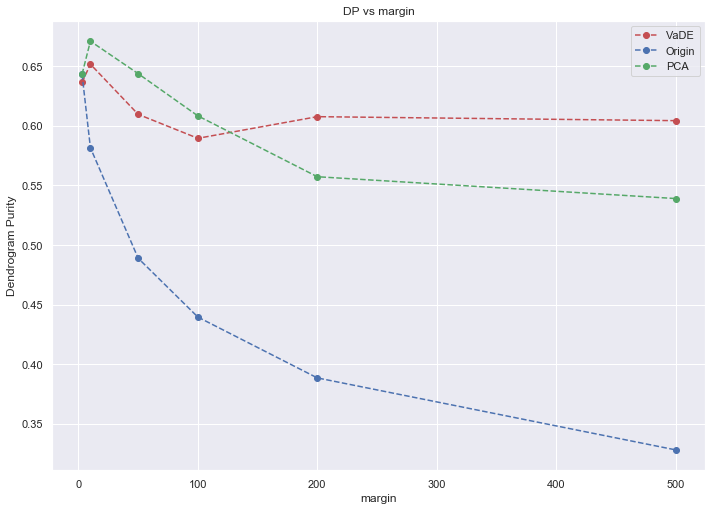

[0.6363762625561432, 0.65165785059617, 0.6095985471733621, 0.5895068953982603, 0.6076533566585174, 0.604308989171724]
[0.6432768651946782, 0.5815741638898616, 0.488947261381297, 0.4396001957510272, 0.3885890485003738, 0.3282487413083144]
[0.6432768651946782, 0.6709575447585236, 0.6437213951096459, 0.6083199628623923, 0.5572915086302281, 0.5389963295530957]


In [52]:
x = [3, 10, 50, 100, 200, 500]
DP_normal = []
DP_pca = []
for i in x:
    dim = i
    n_class = 8
    margin = 4
    var = 1
    synthetic_data, cla = gen_synthetic(dim, margin, n_class, var, 5000)
    perm = np.random.permutation(40000)
    synthetic_data = synthetic_data[perm]
    cla = cla[perm]
    Z_normal = linkage(synthetic_data[:800], "ward")
    DP_normal.append(compute_purity(Z_normal, cla[:800], 8))
    
    pca = PCA(n_components = 3)
    projection = pca.fit_transform(synthetic_data[:800])
    Z = linkage(projection, "ward")
    DP_pca.append(compute_purity(Z, cla[:800], 8))

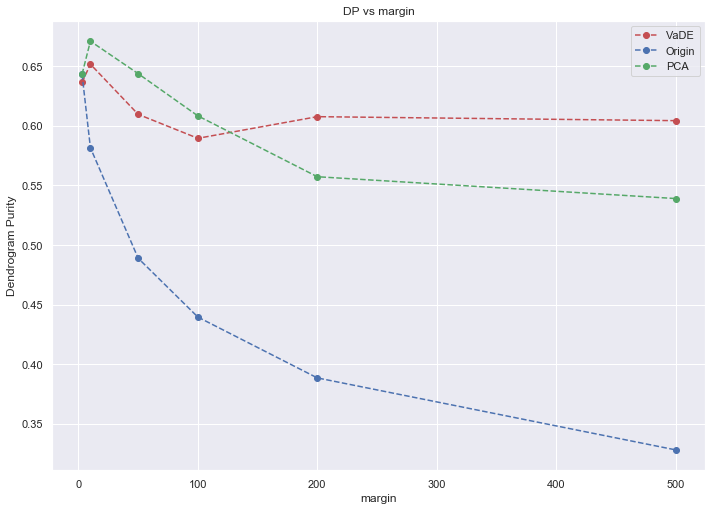

[0.6363762625561432, 0.65165785059617, 0.6095985471733621, 0.5895068953982603, 0.6076533566585174, 0.604308989171724]
[0.6432768651946782, 0.5815741638898616, 0.488947261381297, 0.4396001957510272, 0.3885890485003738, 0.3282487413083144]
[0.6432768651946782, 0.6709575447585236, 0.6437213951096459, 0.6083199628623923, 0.5572915086302281, 0.5389963295530957]


In [152]:
fig, ax = plt.subplots()
y1 = DP
y2 = DP_normal
y3 = DP_pca
plt.plot(x, y1, marker='o', linestyle='--', color='r', label = "VaDE") 
plt.plot(x, y2, marker='o', linestyle='--', color='b', label = "Origin") 
plt.plot(x, y3, marker='o', linestyle='--', color='g', label = "PCA") 
plt.xlabel('margin')
plt.ylabel('Dendrogram Purity') 
plt.title('DP vs margin')
plt.legend()
plt.show()
print(DP)
print(DP_normal)
print(DP_pca)

In [153]:
result = {}
result["VaDE"] = DP
result["PCA"] = DP_pca
result["origin"] = DP_normal
with open("Synthetic results/DP_vs_margin.pkl", "wb") as f:
    pickle.dump(result, f)

In [254]:
Z = linkage(data, "average")

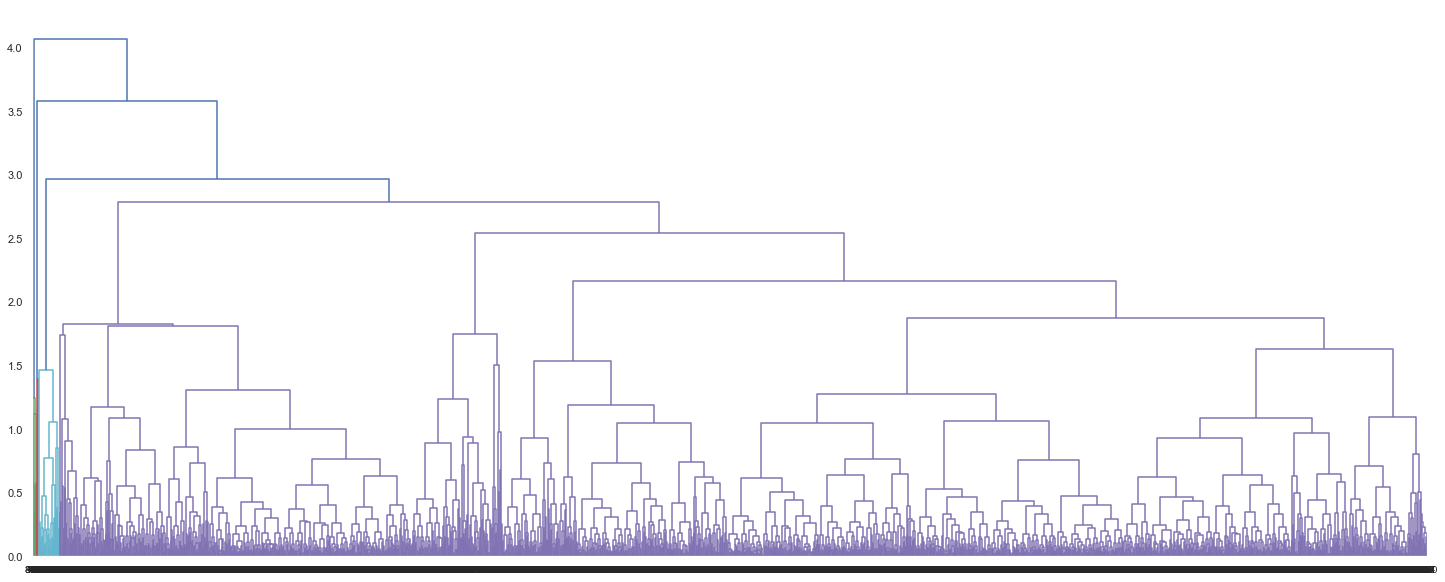

In [255]:
plt.figure(figsize = (25, 10))
d = dendrogram(
            Z,
            leaf_rotation=0.,  # rotates the x axis labels
            leaf_font_size=10.,  # font size for the x axis labels
            get_leaves = True
        )
plt.show()

In [343]:
def average_distance(set1, set2):
    dist = 0
    for i in set1:
        for j in set2:
            dist += np.linalg.norm(i - j)
    return dist / (len(set1) * len(set2))

class Linkage():
    def __init__(self, data, k_init = None, threshold = 1, method = "Average"):
        self.data = data
        self.clusters = []
        self.c_history = []
        self.method = method
        self.index = data.shape[0]
        self.linkage_matrix = []
        self.distance = {}
        self.threshold = threshold
        self.k_init = k_init


        for i, item in enumerate(data):
            self.clusters.append(([item], i))
            self.c_history.append([item])
            self.distance[i] = {}
            
        for i in range(len(self.clusters)):
            for j in range(len(self.clusters)):
                c1 = self.clusters[i][0]
                c2 = self.clusters[j][0]
                dist = average_distance(c1, c2)
                self.distance[i][j] = dist

    def run_linkage(self):
        # k-mean initiation
        pop_list = list(self.clusters[i] for i in self.k_init)
        for k_c in sorted(self.k_init, reverse=True):
            del self.clusters[k_c]
        for i, k_c in enumerate(self.k_init):
            global_index1 = k_c
            c1 = pop_list[i][0]
            min_dist = 1e10
            for j, d in enumerate(self.clusters):
                dist = average_distance(d[0], c1)
                if dist < min_dist:
                    pop_index2 = j
                    global_index2 = d[1]
                    min_dist = dist
            c2 = self.clusters.pop(pop_index2)[0]        
            new_cluster = c1 + c2
            self.clusters.append((new_cluster, len(self.c_history)))
            self.c_history.append(new_cluster)
            self.distance[len(self.c_history) - 1] = {}
            for i in range(len(self.clusters)):
                global_index = self.clusters[i][1]
                dist = average_distance(new_cluster, self.clusters[i][0])
                self.distance[len(self.c_history) - 1][global_index] = dist
                self.distance[global_index][len(self.c_history) - 1] = dist
            # log the merge information into linkage matrix
            #print(global_index1, global_index2)
            self.linkage_matrix.append([global_index1, global_index2, min_dist, len(c1) + len(c2)])
            
        flag = True
        while flag:
            #print(len(self.clusters))
            min_dist = 1e10
            c1_index = 0
            c2_index = 0
            pop_index1 = 0
            pop_index2 = 0
            # determine what to merge next 
            for i in range(len(self.clusters)):
                for j in range(i+1, len(self.clusters)):
                    c1 = self.clusters[i][0]
                    c2 = self.clusters[j][0]
                    if len(c1) < self.threshold and len(c2) < self.threshold:
                        continue
                    c1_global_index = self.clusters[i][1]
                    c2_global_index = self.clusters[j][1]
                    #print(c1, c2)
                    dist = self.distance[c1_global_index][c2_global_index]
                    if dist < min_dist:
                        min_dist = dist
                        c1_index = c1_global_index
                        c2_index = c2_global_index
                        pop_index1 = i
                        pop_index2 = j
            # create new cluster
            new_cluster = self.clusters[pop_index1][0] + self.clusters[pop_index2][0]
            c1 = self.clusters.pop(pop_index1)[0]
            c2 = self.clusters.pop(pop_index2 - 1)[0]
            self.clusters.append((new_cluster, len(self.c_history)))
            self.c_history.append(new_cluster)
            self.distance[len(self.c_history) - 1] = {}
            for i in range(len(self.clusters)):
                global_index = self.clusters[i][1]
                dist = average_distance(new_cluster, self.clusters[i][0])
                self.distance[len(self.c_history) - 1][global_index] = dist
                self.distance[global_index][len(self.c_history) - 1] = dist
            # log the merge information into linkage matrix
            self.linkage_matrix.append([c1_index, c2_index, min_dist, len(c1) + len(c2)])
            if len(self.clusters) == 1:
                flag = False
        return np.array(self.linkage_matrix)

In [366]:
data, data_cla = gen_synthetic(2, 1, 2, 1, 100)
avl = Linkage(data, np.concatenate([np.arange(10), np.arange(100,110)]), 2)
Z = avl.run_linkage()

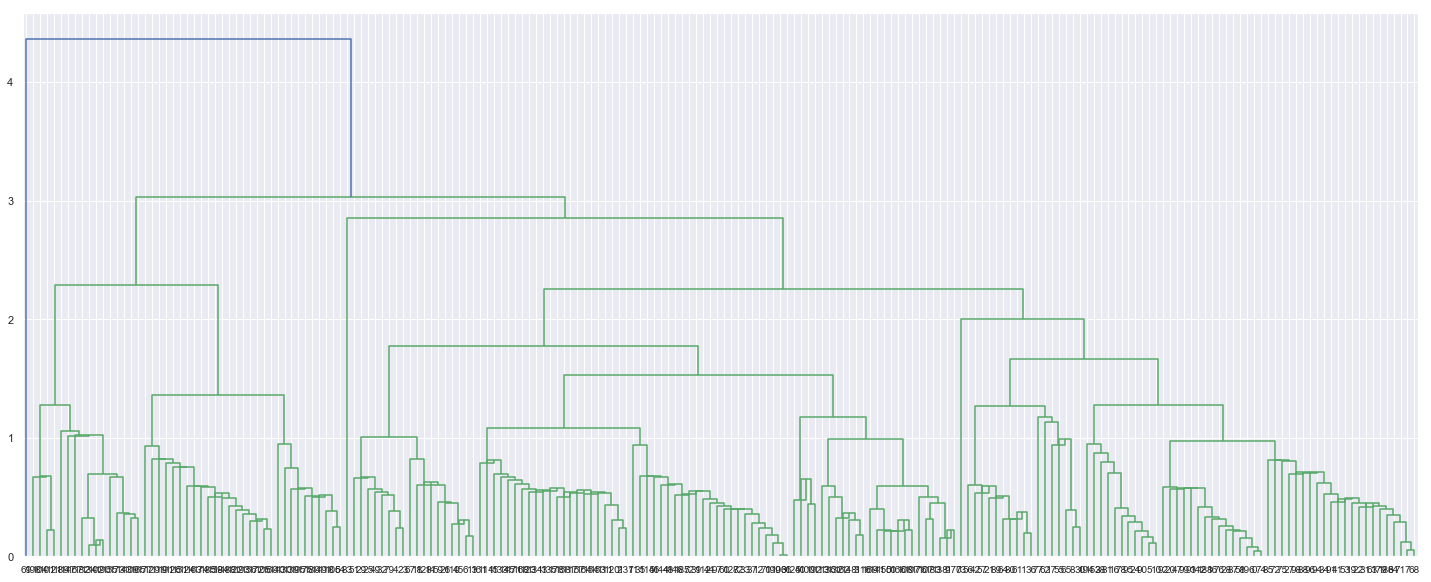

0.495


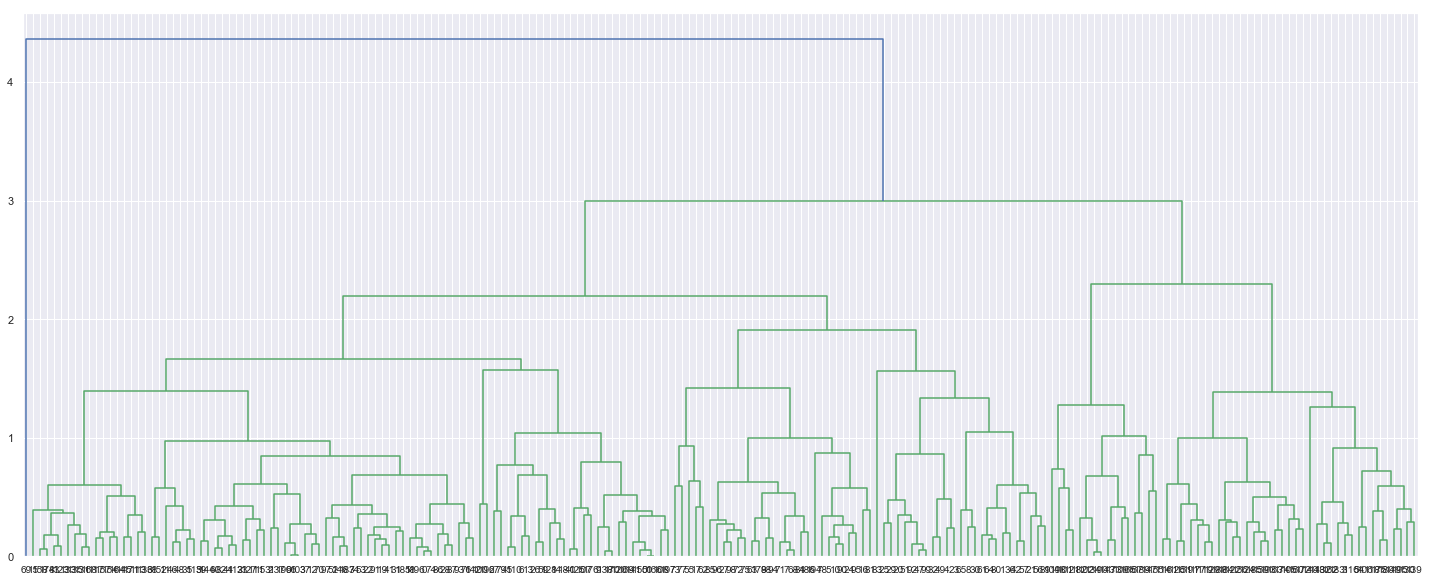

In [367]:
plt.figure(figsize = (25, 10))
d = dendrogram(
            Z,
            leaf_rotation=0.,  # rotates the x axis labels
            leaf_font_size=10.,  # font size for the x axis labels
            get_leaves = True
        )
plt.show()
rootnode, nodelist = scipy.cluster.hierarchy.to_tree(Z, rd=True)
print(misclassified_portion(rootnode))

Z_scipy = linkage(data, "average")
plt.figure(figsize = (25, 10))
d = dendrogram(
            Z_scipy,
            leaf_rotation=0.,  # rotates the x axis labels
            leaf_font_size=10.,  # font size for the x axis labels
            get_leaves = True
        )
plt.show()


ValueError: x and y must have same first dimension, but have shapes (100,) and (50,)

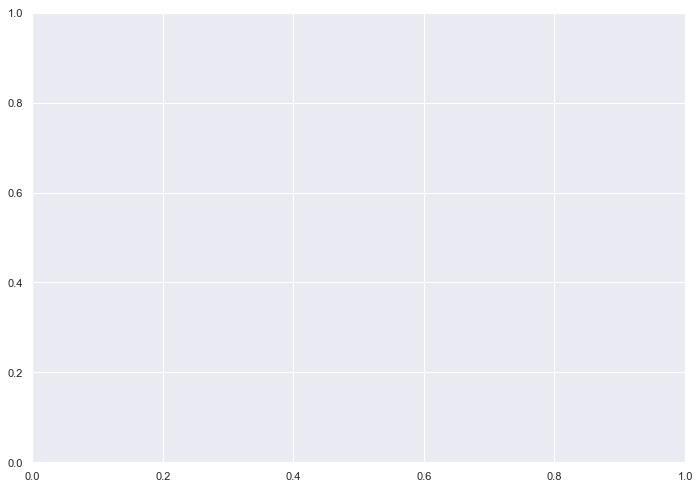

In [372]:
def misclassified_portion(rootnode):
    left_leaves = np.array(list_leaves(rootnode.left))
    right_leaves = np.array(list_leaves(rootnode.right))
    return min((np.sum(left_leaves<100) + np.sum(right_leaves > 100)) / 200, (np.sum(left_leaves>100) + np.sum(right_leaves < 100)) / 200)
def Gaussian_HC(margin, var = 1):
    data, data_cla = gen_synthetic(2, margin, 2, var, 100)
    Z = linkage(data, "average")
    rootnode, nodelist = scipy.cluster.hierarchy.to_tree(Z, rd=True)
    return rootnode
result_scipy = []
for i in range(100):
    #print(i)
    temp = 0
    for j in range(100):
        rootnode = Gaussian_HC(i*4 /100, 1)
        temp += misclassified_portion(rootnode)
    result_scipy.append(temp/100)
plt.plot(np.arange(100) * 4 /100, result)

In [370]:
def misclassified_portion(rootnode):
    left_leaves = np.array(list_leaves(rootnode.left))
    right_leaves = np.array(list_leaves(rootnode.right))
    return min((np.sum(left_leaves<100) + np.sum(right_leaves > 100)) / 200, (np.sum(left_leaves>100) + np.sum(right_leaves < 100)) / 200)
def Gaussian_HC(margin, var = 1):
    data, data_cla = gen_synthetic(2, margin, 2, var, 100)
    avl = Linkage(data, np.concatenate([np.arange(10), np.arange(100,110)]), 2)
    Z = avl.run_linkage()
    #Z = linkage(data, "ward")
    rootnode, nodelist = scipy.cluster.hierarchy.to_tree(Z, rd=True)
    return rootnode

rootnode_list = []
result = []
for i in range(50):
    print(i)
    temp = 0
    rootnode_list.append([])
    for j in range(20):
        rootnode = Gaussian_HC(i*4 /50, 1)
        temp += misclassified_portion(rootnode)
        rootnode_list[i].append(rootnode)
    result.append(temp/20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


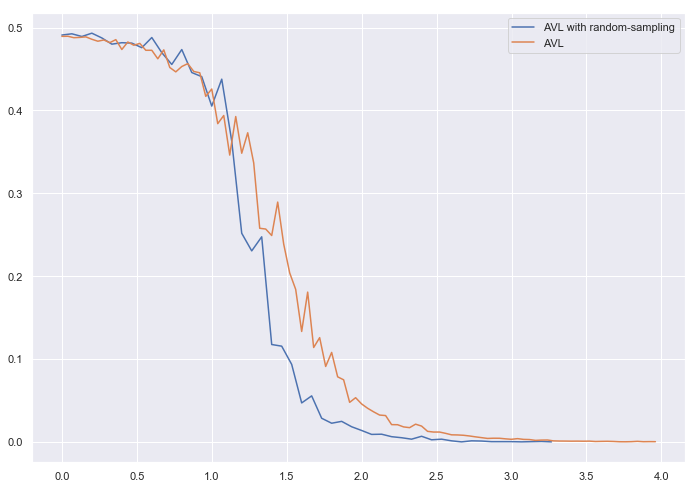

In [374]:
plt.plot(np.arange(50) * 4 /60, result, label = "AVL with random-sampling")
plt.plot(np.arange(100) * 4 /100, result_scipy, label = "AVL")
plt.legend()

In [375]:
with open("Synthetic results/2D_Gaussian_vary_margin_average_improved.pkl", "wb") as f:
    pickle.dump(result, f)
    
with open("Synthetic results/2D_Gaussian_vary_margin_average_improved_rootnode.pkl", "wb") as f:
    pickle.dump(rootnode_list, f)

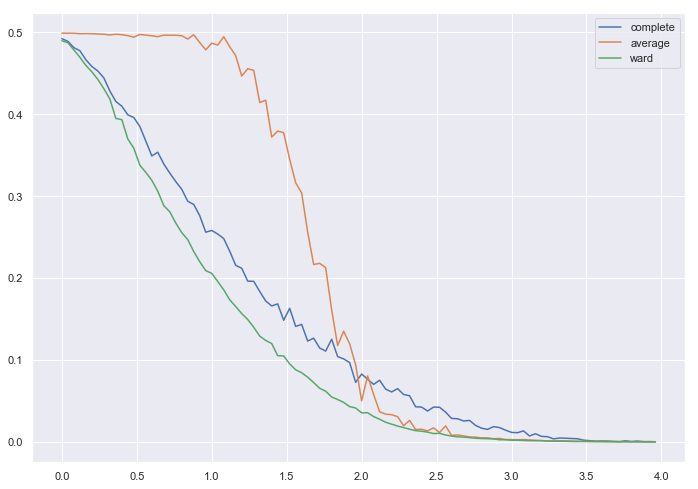

In [377]:
with open("Synthetic results/2D_Gaussian_vary_margin_average.pkl", "rb") as f:
    result_average = pickle.load(f)
with open("Synthetic results/2D_Gaussian_vary_margin_complete.pkl", "rb") as f:
    result_complete = pickle.load(f)
with open("Synthetic results/2D_Gaussian_vary_margin_ward.pkl", "rb") as f:
    result_ward = pickle.load(f)
plt.plot(np.arange(100) * 4 /100, result_complete, label = "complete")  
plt.plot(np.arange(100) * 4 /100, result_average, label = "average")  
plt.plot(np.arange(100) * 4 /100, result_ward, label = "ward") 
plt.legend()
plt.show()